In [2]:
%cd ..
%load_ext autoreload
%autoreload 2

/hdd/aouadt/these/projets/3d_segm


In [3]:
from importlib import reload
from functools import partial
from typing import Tuple, Callable, List
from IPython.display import clear_output
import time
import random
import itertools

import numpy as np
import pandas as pd
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import torch
import torch.nn as nn
import k3d
import skimage.morphology as morp
from tqdm.notebook import tqdm
import skimage.morphology as morp
from scipy.signal import convolve2d

import deep_morpho.binarization.dichotomy_binarization as db
import deep_morpho.binarization.bise_closest_selem as bcs
import deep_morpho.binarization.projection_constant_set as pcs

# matplotlib.rcParams['axes.grid'] = True

def reload_modules():
    for modl in [
        db, bcs
    ]:
        reload(modl)

In [4]:

import general.nn.viz.canva as cva
import general.nn.viz.element as viz_element
import general.nn.viz.plot_symbols as ps
import general.nn.viz.plot_letters as plet
import general.nn.viz.element_symbols as es
import general.nn.viz.element_image as ei
import general.nn.viz.element_arrow as ea
import general.nn.viz.element_circle as ec
import general.nn.viz.element_letters as el
import general.nn.viz.plot_histogram as ph
import general.nn.viz as all_viz
import general.array_morphology as arm
import deep_morpho.viz.elt_generator_init as egen_init
import deep_morpho.viz.element_arrow_no as eltarno
import deep_morpho.morp_operations as mo
import deep_morpho.viz.morp_operations_viz as mov
import deep_morpho.viz.elt_generator_morpop as elgenmo
import deep_morpho.datasets.generate_forms3 as gfo3


# import deep_morpho.viz.morp_operations_viz2 as mov2

import deep_morpho.threshold_fn as tfn
import deep_morpho.initializer.bimonn_initializer as bimonn_init
import deep_morpho.models.weights_layer as wl
import deep_morpho.models.bise_base as bise_base
import deep_morpho.models.lui as lui
import deep_morpho.models.dense_lui as dense_lui
import deep_morpho.models.bisel as bisel 
import deep_morpho.models.bimonn as bimonn
import deep_morpho.viz.element_lui as elui
# import deep_morpho.viz.element_lui2 as elui2
import deep_morpho.viz.element_bise as ebise
import deep_morpho.viz.element_generator as egen
import deep_morpho.viz.skeleton_morp_viz as skmov
import deep_morpho.viz.elt_generator_init as egen_init
import deep_morpho.viz.elt_generator_bimonn as egen_bimonn
import deep_morpho.viz.bimonn_viz as bviz
# import deep_morpho.viz.bimonn_viz2 as bviz2

import deep_morpho.datasets.generate_forms3 as gf3

def reload_modules():
    for modl in [
        cva, viz_element, ps, plet, es, ei, ea, ec, el, ph, all_viz, arm, egen_init, eltarno, mo, mov, elgenmo, db,
        tfn, bimonn_init, wl, lui, dense_lui, bisel, bimonn, elui, ebise, bviz, egen, skmov, egen_init, egen_bimonn, gf3
    ]:
        reload(modl)

# Weak Activation

In [115]:
def get_almost_binary(X, delta):
    I = np.zeros(X.shape)
    I[X == 1] = np.random.uniform(1/2 + delta, 1, X[X == 1].shape)
    I[X == 0] = np.random.uniform(0, 1/2 - delta, X[X == 0].shape)
    return I


In [28]:
# W = np.array([
#     [0, 0, 0],
#     [1, 0, 1],
#     [0, 1, 0]
# ])
W = np.random.rand(5)
b = np.array([12])
xi = lambda x: 1/2 * np.tanh(x) + 1/2
delta = .4
p = 12

cardS = W.sum()


print("Min delta:", (cardS - 1) / (2 * (cardS +1)))
lb, ub = bise_base.BiSEBase.bias_bounds_dilation(W, W.astype(bool), v1=1/2-delta, v2=1/2+delta)
print("bounds:", lb, ub)
print("activated:", bise_base.BiSEBase.is_dilation_by(W, -b, W.astype(bool), v1=1/2-delta, v2=1/2+delta))
delta_out = min(xi(p * (b - lb)) - 1/2, xi(p * (ub - b)) - 1/2)
print("delta_out", delta_out)


Min delta: 0.2527277023214391
bounds: 0.30441246730353094 0.044407532731149744
activated: [False]
delta_out [-0.5]


In [240]:
N  = 5
W[np.arange(N)]
np.concatenate(([0], np.cumsum(W[np.arange(N-1)])))

array([0, 1, 2, 3, 3])

bounds: 0 1


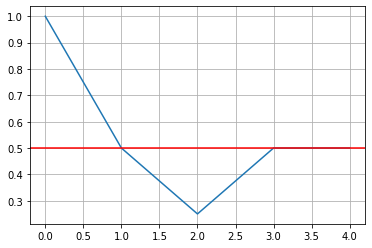

In [222]:
W = np.sort(np.random.rand(5))
W = np.sort(np.array([0, 0, 1, 1, 1]))[::-1]
lb, ub = bise_base.BiSEBase.bias_bounds_dilation(W, W.astype(bool), v1=0, v2=1)
print("bounds:", lb, ub)

all_deltas = []
for k in range(1, W.shape[0]+1):
    all_deltas.append(
        (W[k:].sum() + 1/2 * W[:k].sum() - 1/2 * W[:k].min()) / (W[:k].min() + W[:k].sum())
    )

plt.plot(range(len(all_deltas)), all_deltas)
plt.grid()
plt.axhline(1/2, color="r")
# plt.ylim(0, 1)

In [361]:
def find_activated_weights(W, delta=1/2):
    N = W.shape[0]
    pos = (
        W[np.arange(N)] * (1/2 + delta) - 
        np.concatenate(([0], np.cumsum(W[np.arange(N-1)])))
        - (1/2 - delta) * np.cumsum(W[np.arange(N-1, -1, -1)])
    ) > 0
    return [W >= W[i] for i in np.where(pos)[0]]

W = np.sort(np.random.rand(5))
print(W)
find_activated_weights(W, delta=.4)


[0.11377253 0.86301737 0.88814083 0.89417163 0.91362272]


[array([ True,  True,  True,  True,  True]),
 array([False,  True,  True,  True,  True])]

In [374]:
# W = np.sort(np.random.rand(5))
delta = .4
# W[2] = 0
W = np.array([0, 0, .5, 1, 1])
S = random.choice(find_activated_weights(W, delta=delta))
print(W)
print(S)

lb, ub = bise_base.BiSEBase.bias_bounds_dilation(W, S, v1=1/2-delta, v2=1/2+delta)
# lb, ub = bise_base.BiSEBase.bias_bounds_dilation(W, np.ones_like(W).astype(bool), v1=1/2-delta, v2=1/2+delta)
# lb, ub = bise_base.BiSEBase.bias_bounds_dilation(W, W.astype(bool), v1=1/2-delta, v2=1/2+delta)
print("bounds:", lb, ub)

all_sets = []
for r in range(len(W)+1):
    sets = itertools.combinations(W, r)
    all_sets.extend(sets)

possible_boolean_values = [np.array([False, True])] * len(W)
all_intervals = np.zeros((2**len(W), 2))
all_Xs = np.zeros((2**len(W), len(W)))
for idx, X in enumerate(list(itertools.product(*possible_boolean_values))):
    X = np.array(X)
    all_intervals[idx] = (
        (1/2 + delta) * W[X].sum(), W[X].sum() + (1/2 - delta) * W[~X].sum()
    )
    all_Xs[idx] = X
    # all_intervals.append(
    #     ((1/2 + delta) * W[X].sum(), W[X].sum() + (1/2 - delta) * W[~X].sum())
    # )

sort_idx = np.argsort(all_intervals[:, 0])
all_intervals = all_intervals[sort_idx]
all_Xs = all_Xs[sort_idx]

print(*[(f"{k[0]:.4f}, {k[1]:.4f}", v.astype(int)) for (k, v) in zip(all_intervals, all_Xs)], sep="\n")


[0.  0.  0.5 1.  1. ]
[False False  True  True  True]
bounds: 0.24999999999999994 0.45
('0.0000, 0.2500', array([0, 0, 0, 0, 0]))
('0.0000, 0.2500', array([1, 0, 0, 0, 0]))
('0.0000, 0.2500', array([1, 1, 0, 0, 0]))
('0.0000, 0.2500', array([0, 1, 0, 0, 0]))
('0.4500, 0.7000', array([0, 0, 1, 0, 0]))
('0.4500, 0.7000', array([1, 1, 1, 0, 0]))
('0.4500, 0.7000', array([0, 1, 1, 0, 0]))
('0.4500, 0.7000', array([1, 0, 1, 0, 0]))
('0.9000, 1.1500', array([0, 0, 0, 1, 0]))
('0.9000, 1.1500', array([0, 0, 0, 0, 1]))
('0.9000, 1.1500', array([0, 1, 0, 0, 1]))
('0.9000, 1.1500', array([0, 1, 0, 1, 0]))
('0.9000, 1.1500', array([1, 1, 0, 1, 0]))
('0.9000, 1.1500', array([1, 0, 0, 1, 0]))
('0.9000, 1.1500', array([1, 1, 0, 0, 1]))
('0.9000, 1.1500', array([1, 0, 0, 0, 1]))
('1.3500, 1.6000', array([1, 0, 1, 1, 0]))
('1.3500, 1.6000', array([1, 0, 1, 0, 1]))
('1.3500, 1.6000', array([0, 1, 1, 0, 1]))
('1.3500, 1.6000', array([0, 1, 1, 1, 0]))
('1.3500, 1.6000', array([1, 1, 1, 0, 1]))
('1.3500, 

In [410]:
X = np.random.randint(0, 2, W.shape)
Xb = X.astype(bool)
print(X)
print((W * X).sum())
print((W * X).sum() > b)

[0 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 1 0 1]
10.820922810081916
[False]


In [412]:
W[Xb].sum(), W[Xb].sum() - W[~Xb].min()

(10.820922810081916, 10.773593561255238)

In [411]:
I = get_almost_binary(X, delta)
I[~Xb] = 0
print(I)

print((W * I).sum())
print((W * I).sum() > b)

[0.         0.         0.9263813  0.9919443  0.         0.94076674
 0.99426665 0.         0.97991493 0.         0.         0.
 0.9597864  0.92245378 0.93097229 0.         0.         0.90122516
 0.93506793 0.96648546 0.96031712 0.99268033 0.         0.
 0.         0.         0.         0.97556231 0.92311373 0.99563823
 0.         0.         0.96681208 0.         0.99861151 0.93583078
 0.         0.         0.96561662 0.         0.         0.97898466
 0.98220309 0.         0.         0.         0.         0.97600465
 0.         0.95027135]
10.370707947815399
[False]


In [431]:
def matrix(X, Xbar):
    A = np.eye(X + Xbar)
    A[0, :X] = 1
    A[X, X:] = 1
    return A


In [434]:
np.linalg.inv(A)

array([[ 1., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

# Ternary Weight Networks Computation

In [26]:
# Article: https://arxiv.org/pdf/2103.03123.pdf

alpha = 5
sigma = 1
N = 10000

# W = np.random.uniform(-alpha, alpha, size=(N,))
# W = np.random.randn(N) * sigma
Wabs = np.sort(np.random.uniform(0, alpha, size=(N,)))[::-1]

# Wabs = np.array(sorted(np.abs(W))[::-1])

(array([1021.,  994., 1009., 1000.,  958., 1035., 1035.,  986.,  989.,
         973.]),
 array([2.07725165e-05, 4.99963317e-01, 9.99905862e-01, 1.49984841e+00,
        1.99979095e+00, 2.49973350e+00, 2.99967604e+00, 3.49961859e+00,
        3.99956113e+00, 4.49950368e+00, 4.99944622e+00]),
 <BarContainer object of 10 artists>)

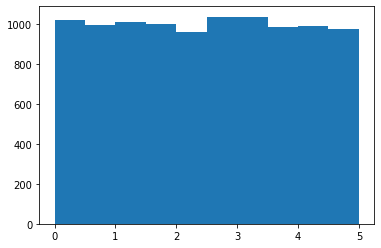

In [29]:
plt.hist(Wabs)

In [6]:
def get_Wt(W, delta):
    Idelta = np.abs(W) >= delta
    alpha = np.abs(W)[Idelta].sum() / (Idelta.sum() )

    Wt = np.zeros_like(W)
    Wt[W <= -delta] = -alpha
    Wt[W >= delta] = alpha

    return Wt

In [27]:
all_dists = (Wabs.cumsum()) ** 2 / np.arange(1, N + 1)


kmax = all_dists.argmax()
delta = Wabs[kmax]
print(delta)

# Wt = get_Wt(W, delta)
# print(((Wt - W) ** 2).sum())

# kmin = all_dists.argmin()
# delta = Wabs[kmin]

# Wt = get_Wt(W, delta)
# print(((Wt - W) ** 2).sum())

1.660767342313566


In [19]:
all_dists

array([7.34384384e-08, 2.04496658e-07, 1.11276938e-06, ...,
       6.26890962e+04, 6.27078649e+04, 6.27266355e+04])

In [14]:
delta

4.9997177324703

In [28]:
delta_uni = 2/3 * Wabs.mean()
print(delta_uni)
# delta_normal = 0.6 * W.std()
# Wt = get_Wt(W, delta_normal)
# Wt = get_Wt(W, delta_uni)
# print(((Wt - W) ** 2).sum())

1.6590838378892467


In [16]:
Wabs

array([2.70995274e-04, 3.68530578e-04, 1.18757791e-03, ...,
       4.99781304e+00, 4.99958957e+00, 4.99971773e+00])

In [118]:
print(delta_uni)
print(delta_normal)
print(delta)

0.5339779906886144
0.6009739042935367
0.6112523306846244


In [69]:
all_dists2 = np.zeros_like(all_dists)
for idx, wval in enumerate(np.unique(np.abs(W))[::-1]):
    Wt = get_Wt(W, wval)
    all_dists2[idx] = ((Wt - W) ** 2).sum()

In [70]:
(W ** 2).sum() - all_dists

array([876.15617406, 851.99469758, 828.25124254, 804.99417435,
       782.58032742, 760.45031597, 739.55847392, 718.70802078,
       697.87767041, 677.0658312 , 657.1502149 , 637.51479737,
       617.98116005, 598.65736745, 579.88627162, 561.39788462,
       543.3948815 , 525.9907699 , 509.10305636, 492.74580341,
       476.44758448, 460.70541834, 445.77855455, 431.10091743,
       416.7470906 , 403.59365599, 390.40885307, 377.99256631,
       365.7555791 , 354.19498875, 342.8483909 , 331.57623596,
       320.49230452, 309.46861046, 298.49028954, 287.86077123,
       277.68459895, 267.90175803, 258.12932731, 248.48268623,
       238.85707188, 229.23838229, 219.91721583, 211.33890428,
       202.72761406, 194.28959802, 186.0641934 , 178.35013336,
       170.92016057, 164.19381318, 157.49261519, 151.32323037,
       145.34195522, 139.62741444, 133.95583763, 128.61636819,
       123.39073301, 118.49797671, 113.60532068, 108.85290202,
       104.36838083,  99.86830126,  95.32621676,  91.16

In [71]:
all_dists2

array([876.15617406, 851.99469758, 828.25124254, 804.99417435,
       782.58032742, 760.45031597, 739.55847392, 718.70802078,
       697.87767041, 677.0658312 , 657.1502149 , 637.51479737,
       617.98116005, 598.65736745, 579.88627162, 561.39788462,
       543.3948815 , 525.9907699 , 509.10305636, 492.74580341,
       476.44758448, 460.70541834, 445.77855455, 431.10091743,
       416.7470906 , 403.59365599, 390.40885307, 377.99256631,
       365.7555791 , 354.19498875, 342.8483909 , 331.57623596,
       320.49230452, 309.46861046, 298.49028954, 287.86077123,
       277.68459895, 267.90175803, 258.12932731, 248.48268623,
       238.85707188, 229.23838229, 219.91721583, 211.33890428,
       202.72761406, 194.28959802, 186.0641934 , 178.35013336,
       170.92016057, 164.19381318, 157.49261519, 151.32323037,
       145.34195522, 139.62741444, 133.95583763, 128.61636819,
       123.39073301, 118.49797671, 113.60532068, 108.85290202,
       104.36838083,  99.86830126,  95.32621676,  91.16

# Matrix for computation of measure of A(S)

## Erosion

In [43]:
def matrix_erosion(S, Sbar):
    A = np.zeros((S + Sbar + 1, S + Sbar + 1))
    A[:S, :S] = np.eye(S) - 1
    A[:S, S:-1] = -1
    A[:S, -1] = 1

    A[S:-1, S:-1] = np.eye(Sbar)

    A[-1, :S] = 1
    A[-1, -1] = -1
    return A

In [53]:
S = 5
Sbar = 2

A = matrix_erosion(S, Sbar)
print(A)
print(np.linalg.inv(A))
print(np.linalg.det(A))

[[ 0. -1. -1. -1. -1. -1. -1.  1.]
 [-1.  0. -1. -1. -1. -1. -1.  1.]
 [-1. -1.  0. -1. -1. -1. -1.  1.]
 [-1. -1. -1.  0. -1. -1. -1.  1.]
 [-1. -1. -1. -1.  0. -1. -1.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  1.  1.  1.  1.  0.  0. -1.]]
[[ 1.00000000e+00  7.40148683e-17  2.22044605e-16 -5.55111512e-17
  -7.40148683e-17  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 7.40148683e-17  1.00000000e+00  2.22044605e-16 -5.55111512e-17
  -7.40148683e-17  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 7.40148683e-17  7.40148683e-17  1.00000000e+00 -5.55111512e-17
  -7.40148683e-17  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 7.40148683e-17  7.40148683e-17  7.40148683e-17  1.00000000e+00
  -7.40148683e-17  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 1.83186799e-16  1.83186799e-16  1.83186799e-16  1.24900090e-16
   1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 4.44089210e-17  4.44089210e-17  4.44089210e-17 -0.0

In [57]:
def matrix_erosion2(S):
    A = np.zeros((S + 1, S + 1))
    A[:S, :S] = np.eye(S) - 1
    A[:S, -1] = 1
    A[-1, :S] = 1
    A[-1, -1] = -1
    return A

A = matrix_erosion2(S)
print(A)
print(np.linalg.det(A))


[[ 0. -1. -1. -1. -1.  1.]
 [-1.  0. -1. -1. -1.  1.]
 [-1. -1.  0. -1. -1.  1.]
 [-1. -1. -1.  0. -1.  1.]
 [-1. -1. -1. -1.  0.  1.]
 [ 1.  1.  1.  1.  1. -1.]]
-0.9999999999999998


## Dilation

In [5]:
from scipy.special import factorial, beta, comb

def ratio_activated(Omega):
    S = np.arange(1, Omega+1)
    return 1 / factorial(Omega - S) * beta(S + 1, Omega - S + 1)


Text(0.5, 1.0, 'For all $S$ per card(S). ${card}(\\Omega) =$49')

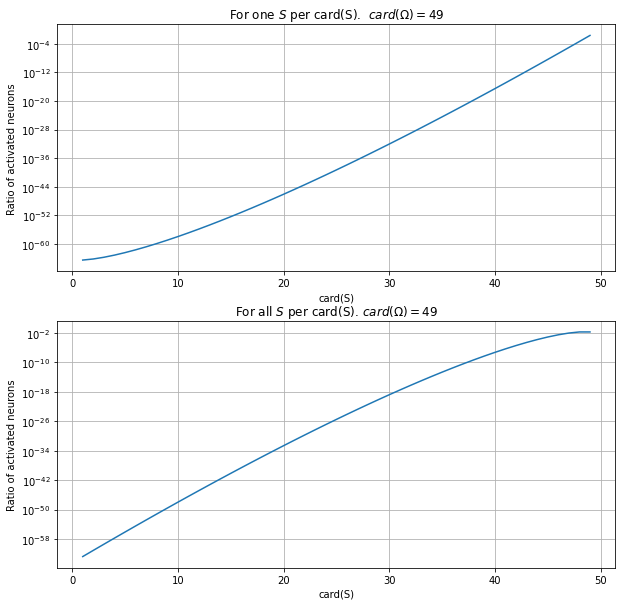

In [17]:
Omega = 7*7
S = np.arange(1, Omega+1)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(S, ratio_activated(Omega))
plt.xlabel('card(S)')
plt.ylabel('Ratio of activated neurons')
plt.yscale('log')
plt.grid()
plt.title(r"For one $S$ per card(S).  ${card}(\Omega) =$" + f"{Omega}")

plt.subplot(212)
plt.plot(S, ratio_activated(Omega)*comb(Omega, np.arange(1, Omega+1)))
plt.xlabel('card(S)')
plt.ylabel('Ratio of activated neurons')
plt.yscale('log')
plt.grid()
plt.title(r"For all $S$ per card(S). ${card}(\Omega) =$" + f"{Omega}")


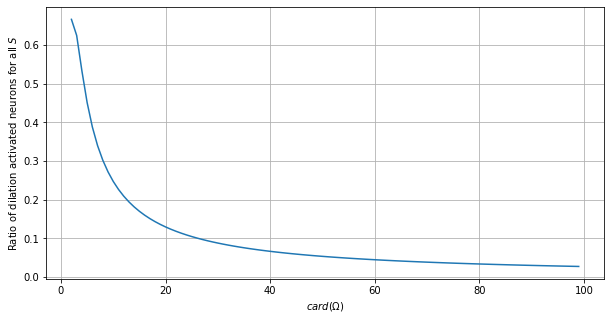

In [19]:
Omegas = np.arange(2, 100)
ratios = np.zeros_like(Omegas).astype(float)
for idx, omega in enumerate(Omegas):
    ratios[idx] = (ratio_activated(omega) * comb(omega, np.arange(1, omega+1))).sum()

plt.figure(figsize=(10, 5))
plt.plot(Omegas, ratios)
plt.xlabel(r'$card(\Omega)$')
plt.ylabel('Ratio of dilation activated neurons for all $S$')
# plt.yscale('log')
plt.grid()

In [6]:
def system(S, Sbar):
    J = np.eye(S + Sbar + 1)

    J[-1, S:-1] = -1
    J[:S, -1] = -1
    return J



In [17]:
J = system(2, 3)
np.linalg.det(np.linalg.inv(J))
np.linalg.det(J)

1.0

In [34]:
def system2(Sbar):
    J = np.eye((Sbar + 1))
    J[-1, :] = 1
    return J

In [37]:
np.linalg.inv(system2(4))
# np.linalg.det(system2(4))


array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [-1., -1., -1., -1.,  1.]])

In [35]:
system2(4)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 1., 1., 1., 1.]])

# Morpho Regu

In [6]:
n_chouts = 100
n_params = 49

W = np.random.rand(n_chouts, n_params)
B = np.random.rand(n_chouts)

proj = pcs.ProjectionConstantSet(W, B)

proj.compute()



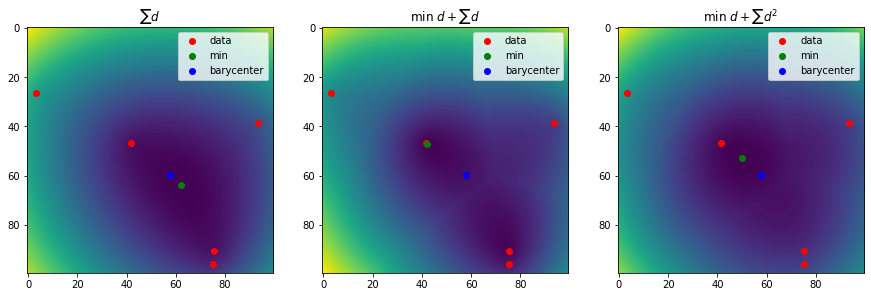

In [39]:
cs = np.random.rand(5, 2)

res = 100
XX, YY = np.meshgrid(np.arange(res), np.arange(res))
all_dists = np.stack([np.sqrt((XX / res - i[0])**2 + (YY / res - i[1])**2) for i in cs], axis=0)

def plot_all_ZZs(ZZs, titles=None, res=res):
    fig, axs = plt.subplots(1, len(ZZs), figsize=(15, 5), squeeze=False)
    for i, ZZ in enumerate(ZZs):
        min_coords = np.where(ZZ == ZZ.min())
        axs[0, i].scatter(cs[:, 0]*res, cs[:, 1]*res, c="r", label="data")
        axs[0, i].scatter(min_coords[1], min_coords[0], c="g", label="min")
        axs[0, i].scatter(np.mean(cs[:, 0]*res), np.mean(cs[:, 1]*res), c="b", label="barycenter")
        axs[0, i].legend()
        axs[0, i].imshow(ZZ)
        if titles is not None:
            axs[0, i].set_title(titles[i])


plot_all_ZZs(
    [
        all_dists.sum(axis=0),
        # ((all_dists)**2).sum(axis=0),
        all_dists.min(axis=0) + all_dists.sum(axis=0),
        all_dists.min(axis=0) + ((all_dists)**2).sum(axis=0),
        # all_dists.min(axis=0),
    ],
    [
        r"$\sum d$",
        # r"$\sum d^2$",
        r"$\min~d + \sum d$",
        r"$\min~d + \sum d^2$",
        # r"$\min~d$",
    ]
)



# Concatenate Convolution

In [22]:
img = np.random.rand(100, 100)
w1 = np.random.randint(0, 2, (5, 1))
w2 = np.random.randint(0, 2, (1, 5))
# w1 = np.array([
#     [3], [4], [5]
# ])
# w2 = np.array([
#     [1, 2, 3]
# ])

wcat = w1 @ w2

conv1 = convolve2d(convolve2d(img, w1, mode="same"), w2, mode="same")
conv2 = convolve2d(img, wcat, mode="same")

#  Diff
print(np.abs(conv1 - conv2).sum())


0.0


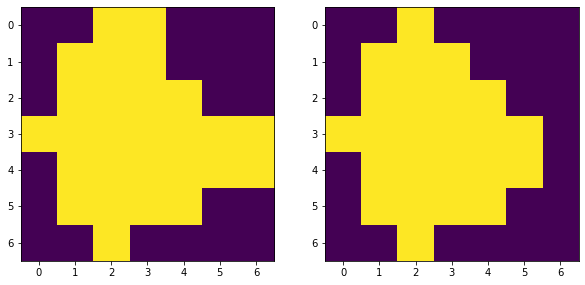

In [25]:
X = np.array([
    [0, 0, 1, 1, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 0],
    [0, 1, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0]
])

S = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
])

ope = morp.opening(X, S)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(X)
plt.subplot(122)
plt.imshow(ope)

# Multi Quanti

(-0.05, 0.05)

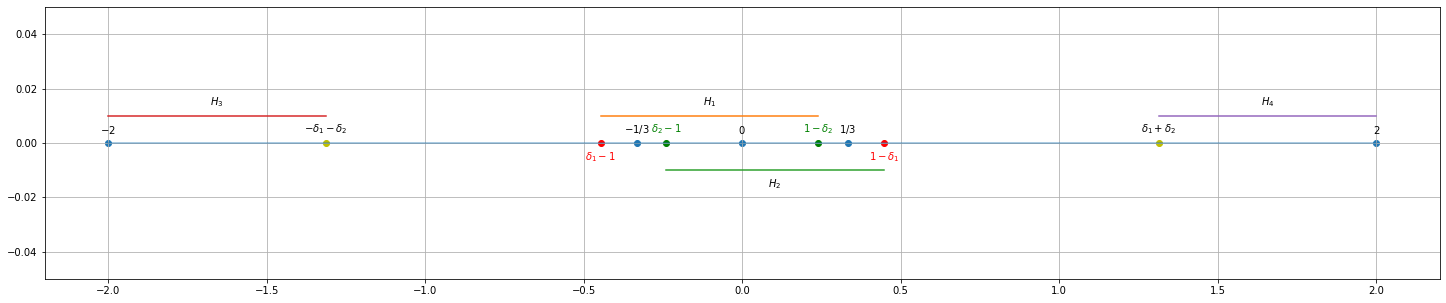

In [117]:
## SYBISE

# delta1 = 5/12
# delta2 = 6/12
delta1 = np.random.uniform(1/3, 1)
delta2 = np.random.uniform(1/3, 1)

plt.figure(figsize=(25, 5))
plt.grid()
plt.plot([-2, 2], [0, 0], alpha=.5)

plt.text(-2, 0.005, r"$-2$", ha='center', va='center', )  
plt.text(2, 0.005, r"$2$", ha='center', va='center', )  
plt.text(1/3, 0.005, r"$1/3$", ha='center', va='center', )  
plt.text(-1/3, 0.005, r"$-1/3$", ha='center', va='center', )  
plt.text(0, 0.005, r"$0$", ha='center', va='center', )  
plt.scatter([-2, 2, 1/3, -1/3, 0], [0, 0, 0, 0, 0], )

# plt.text(delta1, 0.005, r"$\delta_1$", ha='center', va='center', )  
# plt.scatter([delta1], [0], c="k")

# plt.text(delta2, 0.005, r"$\delta_2$", ha='center', va='center', )  
# plt.scatter([delta2], [0], c="k")

plt.text(delta1 + delta2, 0.005, r"$\delta_1 + \delta_2$", ha='center', va='center', )  
plt.scatter([delta1 + delta2], [0], c="y")

plt.text(-delta1 - delta2, 0.005, r"$-\delta_1 - \delta_2$", ha='center', va='center', )  
plt.scatter([-delta1 - delta2], [0], c="y")

plt.text(1 - delta1, -0.005, r"$1 - \delta_1$", ha='center', va='center', c="r")  
plt.scatter([1 - delta1], [0], c="r")

plt.text(1 - delta2, 0.005, r"$1 - \delta_2$", ha='center', va='center', c="g")  
plt.scatter([1 - delta2], [0], c="g")

plt.text(delta1 - 1, -0.005, r"$\delta_1 - 1$", ha='center', va='center', c="r")  
plt.scatter([delta1 - 1], [0], c="r")

plt.text(delta2 - 1, 0.005, r"$\delta_2 - 1$", ha='center', va='center', c="g")  
plt.scatter([delta2 - 1], [0], c="g")


plt.text((delta1 - delta2) / 2, 0.005 + 0.01, r"$H_1$", ha='center', va='center', )  
plt.plot([delta1 - 1, 1 - delta2], [0.01, 0.01])

plt.text((delta2 - delta1) / 2, -0.005 - 0.01, r"$H_2$", ha='center', va='center', )  
plt.plot([delta2 - 1, 1 - delta1], [-0.01, -0.01])

plt.text((-2 -delta1 - delta2) / 2, 0.005 + 0.01, r"$H_3$", ha='center', va='center', )
plt.plot([-2, -delta1 - delta2], [0.01, 0.01])

plt.text((2 + delta1 + delta2) / 2, 0.005 + 0.01, r"$H_4$", ha='center', va='center', )
plt.plot([2, delta1 + delta2], [0.01, 0.01])


plt.ylim(-0.05, 0.05)

(-0.05, 0.05)

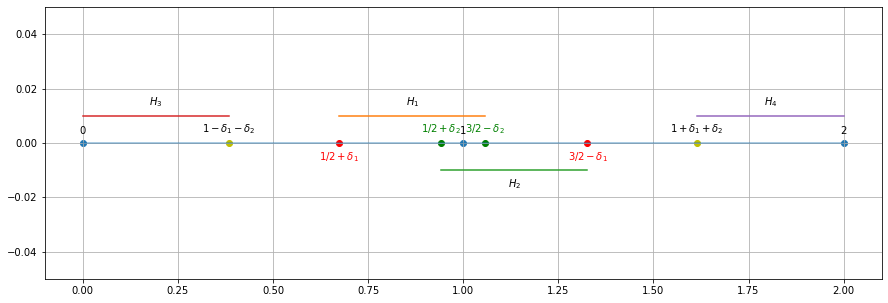

In [114]:
## BISE

# delta1 = 5/12
# delta2 = 6/12
delta1 = np.random.uniform(1/6, 1/2)
delta2 = np.random.uniform(1/6, 1/2)

plt.figure(figsize=(15, 5))
plt.grid()
plt.plot([0, 2], [0, 0], alpha=.5)

plt.text(0, 0.005, r"$0$", ha='center', va='center', )  
plt.text(2, 0.005, r"$2$", ha='center', va='center', )  
# plt.text(1/6, 0.005, r"$1/6$", ha='center', va='center', )
plt.text(1, 0.005, r"$1$", ha='center', va='center', )
plt.scatter([0, 2, 1], [0, 0, 0], )

# plt.text(delta1, 0.005, r"$\delta_1$", ha='center', va='center', )  
# plt.scatter([delta1], [0], c="k")

# plt.text(delta2, 0.005, r"$\delta_2$", ha='center', va='center', )  
# plt.scatter([delta2], [0], c="k")

plt.text(1 + delta1 + delta2, 0.005, r"$1 + \delta_1 + \delta_2$", ha='center', va='center', )  
plt.scatter([1 + delta1 + delta2], [0], c="y")

plt.text(1 -delta1 - delta2, 0.005, r"$1 -\delta_1 - \delta_2$", ha='center', va='center', )  
plt.scatter([1 -delta1 - delta2], [0], c="y")

plt.text(1/2 + delta1, -0.005, r"$1/2 + \delta_1$", ha='center', va='center', c="r")  
plt.scatter([1/2 + delta1], [0], c="r")

plt.text(1/2 + delta2, +0.005, r"$1/2 + \delta_2$", ha='center', va='center', c="g")  
plt.scatter([1/2 + delta2], [0], c="g")


plt.text(3/2 - delta2, 0.005, r"$3/2 - \delta_2$", ha='center', va='center', c="g")  
plt.scatter([3/2 - delta2], [0], c="g")

plt.text(3/2 - delta1, -0.005, r"$3/2 - \delta_1$", ha='center', va='center', c="r")  
plt.scatter([3/2 - delta1], [0], c="r")

plt.text(1 + (delta1 - delta2) / 2, 0.005 + 0.01, r"$H_1$", ha='center', va='center', )  
plt.plot([1/2 + delta1, 3/2 - delta2], [0.01, 0.01])

plt.text(1 + (delta2 - delta1) / 2, -0.005 - 0.01, r"$H_2$", ha='center', va='center', )  
plt.plot([1/2 + delta2, 3/2 - delta1], [-0.01, -0.01])

plt.text((1 -delta1 - delta2) / 2, 0.005 + 0.01, r"$H_3$", ha='center', va='center', )
plt.plot([0, 1 -delta1 - delta2], [0.01, 0.01])

plt.text((3 + delta1 + delta2) / 2, 0.005 + 0.01, r"$H_4$", ha='center', va='center', )
plt.plot([1 +delta1 + delta2, 2], [0.01, 0.01])


plt.ylim(-0.05, 0.05)

## Inter Dila

In [110]:
A = np.array([[0, 1, 0], [1, 2, 1], [0, 0, 0]])
# B = morp.disk(3)
B = np.zeros((7, 7))
B[3, 3] = 2
B[4, 3] = 1

print(A)
print(B)
# print(A, B)

print(convolve2d(B, A, mode="same"))

[[0 1 0]
 [1 2 1]
 [0 0 0]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 2. 5. 2. 0. 0.]
 [0. 0. 1. 2. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


1
1


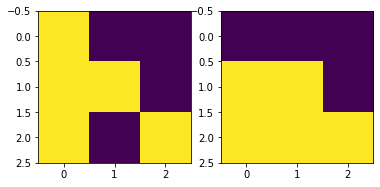

In [78]:
S1 = np.random.randint(0, 2, (3, 3)).astype(bool)

neg_S1 = np.where(~S1)
idx = np.random.randint(0, len(neg_S1[0]))
S2 = S1.copy()
S2[neg_S1[0][idx], neg_S1[1][idx]] = True


neg_S2 = np.where(~S2)
idx = np.random.randint(0, len(neg_S1[0]))
S1[neg_S2[0][idx], neg_S2[1][idx]] = True

print((S1 & (~S2)).sum())
print((S2 & (~S1)).sum())

# S2 = np.random.randint(0, 2, (3, 3)).astype(bool)

plt.subplot(121)
plt.imshow(S1)

plt.subplot(122)
plt.imshow(S2)

In [54]:
def L(W, S1, S2):
    return max(W[~S1].sum(), W[~S2].sum())

def U(W, S1, S2):
    sigma = np.array([[w1 + w2] for w1 in W[S1] for w2 in W[S2] if w1 != w2])
    return min(sigma.min(), W[S1 & S2].min())

2 3
[[1 0 0]
 [3 3 0]
 [3 2 3]]
[[0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]
[[1. 1. 1. 0. 0.]
 [4. 6. 6. 3. 0.]
 [7. 8. 9. 5. 3.]
 [6. 5. 6. 3. 0.]
 [3. 2. 6. 2. 3.]]
True


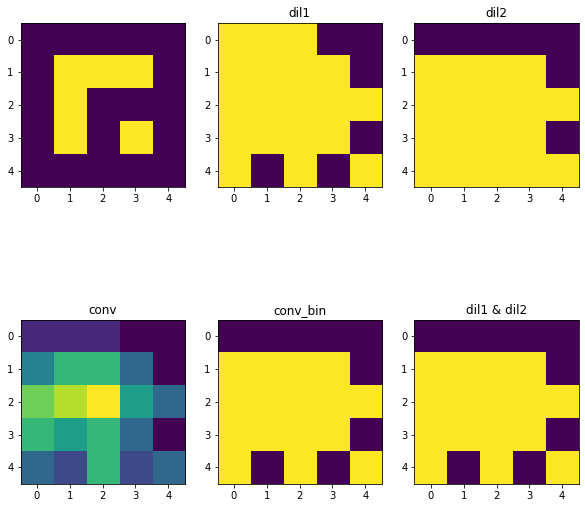

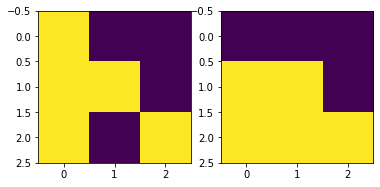

In [127]:
theta1 = 1
theta2 = 2
W = theta1 * S1 + theta2 * S2

print(L(W, S1, S2), U(W, S1, S2))

Xsmall = np.random.randint(0, 2, (3, 3))
X = np.zeros((5, 5))
xd, yd = Xsmall.shape
X[xd//2:-(xd//2), yd//2:-(yd//2)] = Xsmall
# X = np.random.randint(0, 2, (3, 3))

# X = gfo3.get_random_rotated_diskorect(
#     size=(100, 100), 
#     n_shapes=30,
#     max_shape=(15, 15),
#     p_invert=0,
#     border=(0, 0),
#     n_holes=30,
#     max_shape_holes=(7, 7),
#     noise_proba=0
# )

conv = convolve2d(X, W, mode="same")
dil1 = morp.binary_dilation(X, S1).astype(bool)
dil2 = morp.binary_dilation(X, S2).astype(bool)

print(W)
print(X)
print(conv)

# print(dil1)
# print(dil2)

conv_bin = (conv > 2.5)

print((conv_bin == (dil1 & dil2)).all())

plt.figure(figsize=(10, 10))

plt.subplot(231)
plt.imshow(X, interpolation="nearest")

plt.subplot(232)
plt.imshow(dil1, interpolation="nearest")
plt.title("dil1")

plt.subplot(233)
plt.imshow(dil2, interpolation="nearest")
plt.title("dil2")

plt.subplot(234)
plt.imshow(conv)
plt.title("conv")

plt.subplot(235)
plt.imshow(conv_bin)
plt.title("conv_bin")

plt.subplot(236)
plt.imshow(dil1 & dil2)
plt.title("dil1 & dil2")

plt.figure()
plt.subplot(121)
plt.imshow(S1)

plt.subplot(122)
plt.imshow(S2)
# plt.subplot(232)
# plt.imshow(conv_bin - (dil1 & dil2).astype(float), interpolation="nearest")
# plt.title("conv_bin - dil1 & dil2")

# plt.subplot(233)
# plt.imshow(conv_bin, interpolation="nearest", vmin=0, vmax=1)
# plt.title("conv_bin")

# plt.subplot(234)
# plt.imshow(dil1 & dil2, interpolation="nearest", vmin=0, vmax=1)
# plt.title("dil1 & dil2")

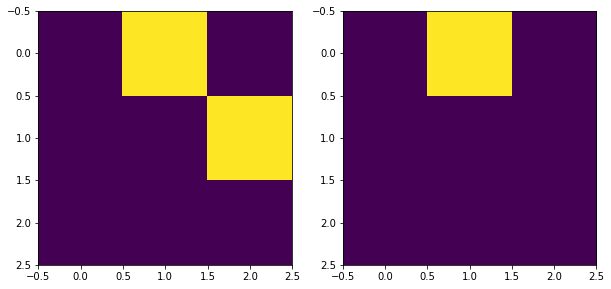

In [3]:
S1_U_S2 = np.random.randint(0, 2, (3, 3))
S1_I_S2 = np.where(np.random.randint(0, 2, (3, 3)), S1_U_S2, 0)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(S1_U_S2)

plt.subplot(122)
plt.imshow(S1_I_S2)

Text(0.5, 1.0, 'Z2')

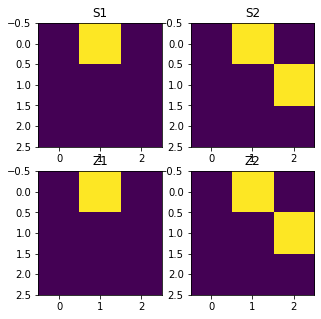

In [4]:
def get_two_sets_from_union_and_inter(S1_U_S2, S1_I_S2):
    """Given the union and intersection of two sets, return one random possiblity for the two sets.
    """
    S1 = np.where(np.random.randint(0, 2, (S1_U_S2.shape)), S1_U_S2, 0)
    S1[np.where(S1_I_S2)] = 1
    
    S2 = S1_U_S2 - S1
    S2[np.where(S1_I_S2)] = 1

    return S1, S2

S1, S2 = get_two_sets_from_union_and_inter(S1_U_S2, S1_I_S2)
# Z1 = S1_I_S2
# Z2 = S1_U_S2
Z1, Z2 = get_two_sets_from_union_and_inter(S1_U_S2, S1_I_S2)


plt.figure(figsize=(5, 5))
plt.subplot(221)
plt.imshow(S1)
plt.title("S1")

plt.subplot(222)
plt.imshow(S2)
plt.title("S2")

plt.subplot(223)
plt.imshow(Z1)
plt.title("Z1")

plt.subplot(224)
plt.imshow(Z2)
plt.title("Z2")


In [137]:
img_small.shape[1] // 2

1

In [5]:
def plot_cell():
    plt.figure(figsize=(15, 10))
    plt.subplot(231)
    plt.imshow(img, interpolation="nearest", cmap="gray", vmin=0, vmax=1)
    plt.title(r"$I$")

    plt.subplot(232)
    plt.imshow(S1_I_S2, interpolation="nearest", vmin=0, vmax=1)
    plt.title(r"$S_1 \cap S_2$")

    plt.subplot(233)
    plt.imshow(S1_U_S2, interpolation="nearest", vmin=0, vmax=1)
    plt.title(r"$S_1 \cup S_2$")

    plt.subplot(234)
    plt.imshow(dilS1_dilS2, interpolation="nearest", cmap="gray", vmin=0, vmax=1)
    plt.title(r"$(I \oplus S_1) \cap (I \oplus S_2)$")

    plt.subplot(235)
    plt.imshow(dilZ1_dilZ2, interpolation="nearest", cmap="gray", vmin=0, vmax=1)
    plt.title(r"$(I \oplus Z_1) \cap (I \oplus Z_2)$")

    plt.subplot(236)
    plt.imshow(dilZ1_dilZ2 - dilS1_dilS2, interpolation="nearest", cmap="gray", vmin=-1, vmax=1)
    plt.title(r"$(I \oplus Z_1) \cap (I \oplus Z_2) - (I \oplus S_1) \cap (I \oplus S_2)$. Sum: {:.0f}".format(np.abs(dilZ1_dilZ2 - dilS1_dilS2).sum()))


# img = gfo3.get_random_rotated_diskorect(
#     size=(100, 100), 
#     n_shapes=30,
#     max_shape=(15, 15),
#     p_invert=0,
#     border=(0, 0),
#     n_holes=30,
#     max_shape_holes=(7, 7),
#     noise_proba=0
# )

# img_small = np.random.randint(0, 2, (S1.shape))
# img_small = 1 - S1

# img = np.zeros(2 * np.array(S1.shape) - 1)
# img[S1.shape[0]//2:-(S1.shape[0]//2), S1.shape[1]//2:-(S1.shape[1]//2)] = img_small


dil_S1 = morp.dilation(img, S1)
dil_S2 = morp.dilation(img, S2)
dil_S12 = morp.dilation(img, S2 & S1)
dilS1_dilS2 = (dil_S1.astype(bool) & dil_S2.astype(bool)).astype(float)

dil_Z1 = morp.dilation(img, Z1)
dil_Z2 = morp.dilation(img, Z2)
dil_Z12 = morp.dilation(img, Z2 & Z1)
dilZ1_dilZ2 = (dil_Z1.astype(bool) & dil_Z2.astype(bool)).astype(float)

plot_cell()

NameError: name 'img' is not defined

Text(0.5, 1.0, '$X \\oplus (S_1 \\cap S_2)$')

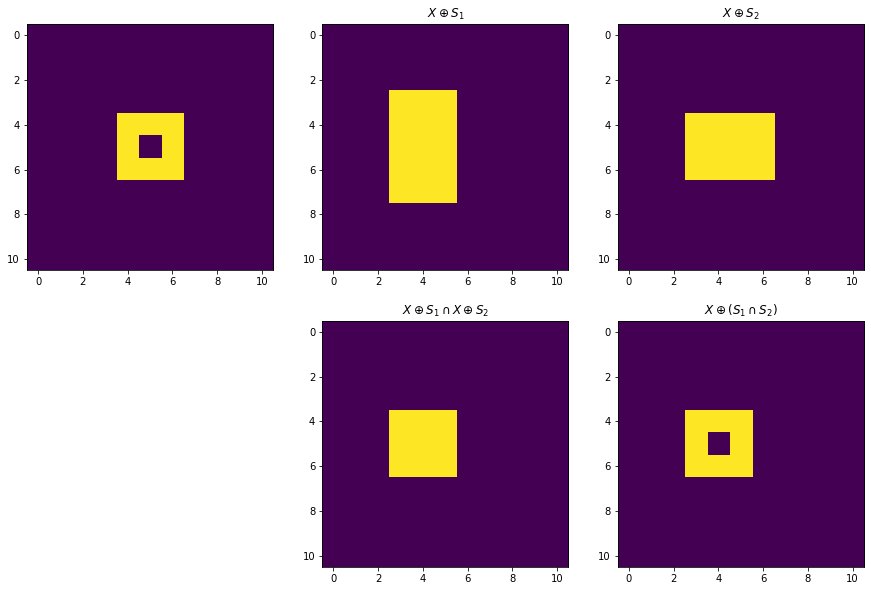

In [66]:
S1 = np.zeros((3, 3))
S2 = np.zeros((3, 3))

S1[:, 0] = 1
S2[1, 1] = 1
S2[1, 0] = 1
# S1[1, :] = 1
# S2[:, 1] = 1

X = np.zeros((11, 11))
X[4:-4, 4:-4] = 1
X[5, 5] = 0

dil1 = morp.binary_dilation(X, S1)
dil2 = morp.binary_dilation(X, S2)

plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(X)

plt.subplot(232)
plt.imshow(dil1)
plt.title(r"$X \oplus S_1$")

plt.subplot(233)
plt.imshow(dil2)
plt.title(r"$X \oplus S_2$")

plt.subplot(235)
plt.imshow((dil1 * dil2))
plt.title(r"$X \oplus S_1 \cap X \oplus S_2$")

plt.subplot(236)
plt.imshow(morp.binary_dilation(X, (S1 + S2) == 2))
plt.title(r"$X \oplus (S_1 \cap S_2)$")

# Matrix Projection Dilation With Negative

In [253]:
def matrix_system_negative(card_kplus, card_kminus, card_T):
    A = np.zeros((card_kplus + card_kminus + card_T + 2, card_kplus + card_kminus + card_T + 2))

    row0, row1 = 0, card_kplus
    col0, col1 = row0, row1

    A[row0:row1, col0:col1] = np.eye(card_kplus)
    A[row0:row1, card_kplus + card_kminus] = 1

    row0 = row1
    row1 = row0 + card_kminus
    
    col0 = col1
    col1 = col0 + card_kminus

    A[row0:row1, col0:col1] = np.eye(card_kminus)
    col0 = col1 + 1
    col1 = col0 + card_T
    A[row0:row1, col0:col1] = -np.ones((card_kminus, card_T))

    row0 = row1
    row1 = row0 + card_T
    col0 = card_kplus
    col1 = col0 + card_kminus

    A[row0:row1, col0:col1] = -np.ones((card_T, card_kminus))
    col0 = col1 + 1
    col1 = col0 + card_T
    A[row0:row1, col0:col1] = -np.eye(card_T)
    A[row0:row1, -1] = 1

    A[-2, card_kplus + card_kminus] = -1
    col0 = card_kplus + card_kminus + 1
    col1 = col0 + card_T + 1
    A[-2, col0:col1] = 1
    A[-2, -1] = 1

    col0 = 0
    col1 = card_kplus
    A[-1, col0:col1] = 1
    A[-1, -1] = -1

    return A


def matrix_inv(Kp, Km, T):
    denom = ((Kp + 1) * (Km * T + 1) + (Kp) * T)
    g = (Kp + 1) / denom
    h = (Kp * T) / denom
    f = T * (Kp + 1) / denom
    c = (T) / denom
    d = 1 / denom
    m = (Kp) / denom
    a = ((Km + 1) * T + 1) / denom
    e = (Km * T + 1)/ denom
    n = Kp * (Km * T + 1)/ denom
    l = (Km * (Kp + 1) + Kp) / denom

    Ainv = np.zeros((Kp + Km + T + 2, Kp + Km + T + 2))
    
    Ainv[:Kp, :Kp] = np.eye(Kp) - a
    Ainv[:Kp, Kp:Kp+Km] = c
    Ainv[:Kp, Kp+Km:Kp+Km+T] = d
    Ainv[:Kp, -2] = e
    Ainv[:Kp, -1] = a

    Ainv[Kp:Kp+Km, :Kp] = c
    Ainv[Kp:Kp+Km, Kp:Kp+Km] = np.eye(Km) - f
    Ainv[Kp:Kp+Km, Kp+Km:Kp+Km+T] = -g
    Ainv[Kp:Kp+Km, -2] = h
    Ainv[Kp:Kp+Km, -1] = -c

    Ainv[Kp+Km, :Kp] = a
    Ainv[Kp+Km, Kp:Kp+Km] = -c
    Ainv[Kp+Km, Kp+Km:Kp+Km+T] = -d
    Ainv[Kp+Km, -2] = -e
    Ainv[Kp+Km, -1] = -a

    Ainv[Kp+Km+1:Kp+Km+T+1, :Kp] = d
    Ainv[Kp+Km+1:Kp+Km+T+1, Kp:Kp+Km] = -g
    Ainv[Kp+Km+1:Kp+Km+T+1, Kp+Km:Kp+Km+T] = l - np.eye(T)
    Ainv[Kp+Km+1:Kp+Km+T+1, -2] = m
    Ainv[Kp+Km+1:Kp+Km+T+1, -1] = -d

    Ainv[-1, :Kp] = e
    Ainv[-1, Kp:Kp+Km] = h
    Ainv[-1, Kp+Km:Kp+Km+T] = m
    Ainv[-1, -2] = n
    Ainv[-1, -1] = -e

    return Ainv

In [254]:
Kplus, Kminus, T = 5, 0, 3

A = matrix_system_negative(Kplus, Kminus, T)
Ainv = np.linalg.inv(A)
Ainv2 = matrix_inv(Kplus, Kminus, T)
print(np.abs(Ainv2 - Ainv).sum())
print(np.abs(Ainv2 @ A - np.eye(A.shape[0])).sum())
# display(A)
# print(np.array_str((Ainv), precision=2, suppress_small=True))
print(np.array_str((Ainv2), precision=2, suppress_small=True))
# print(np.array_str((Ainv2 - Ainv), precision=2, suppress_small=True))

3.3306690738754696e-16
3.885780586188048e-16
[[ 0.81 -0.19 -0.19 -0.19 -0.19  0.05  0.05  0.05  0.05  0.19]
 [-0.19  0.81 -0.19 -0.19 -0.19  0.05  0.05  0.05  0.05  0.19]
 [-0.19 -0.19  0.81 -0.19 -0.19  0.05  0.05  0.05  0.05  0.19]
 [-0.19 -0.19 -0.19  0.81 -0.19  0.05  0.05  0.05  0.05  0.19]
 [-0.19 -0.19 -0.19 -0.19  0.81  0.05  0.05  0.05  0.05  0.19]
 [ 0.19  0.19  0.19  0.19  0.19 -0.05 -0.05 -0.05 -0.05 -0.19]
 [ 0.05  0.05  0.05  0.05  0.05 -0.76  0.24  0.24  0.24 -0.05]
 [ 0.05  0.05  0.05  0.05  0.05  0.24 -0.76  0.24  0.24 -0.05]
 [ 0.05  0.05  0.05  0.05  0.05  0.24  0.24 -0.76  0.24 -0.05]
 [ 0.05  0.05  0.05  0.05  0.05  0.24  0.24  0.24  0.24 -0.05]]


In [221]:
a = Ainv[0, -1]
c = Ainv[0, Kplus]
d = Ainv[0, Kplus + Kminus]
e = Ainv[0, Kplus + Kminus + T]
f = -Ainv[Kplus, Kplus] + 1
g = -Ainv[Kplus, Kplus + Kminus]
h = Ainv[Kplus, Kplus + Kminus + T]
l = Ainv[Kplus + Kminus + 1, Kplus + Kminus] + 1
m = Ainv[Kplus + Kminus + 1, Kplus + Kminus + T]
n = Ainv[-1, -2]

X = np.array([a, c, d, e, f, g, h, l, m, n])

In [222]:
#     a    c   d   e    f   g   h  l   m   n
# u = [ 0,   1, -T,  0,   0,  0,  0, 0,  0,  0]
u = [-1,   0,  T,  1,   0,  0,  0, 0,  0,  0]

np.array(u) @ X

0.0

In [223]:
Kp, Km = Kplus, Kminus
system_un = np.array([
#     a    c   d   e    f   g   h   l   m   n
    [-1,   0,  T,  1,   0,  0,  0,  0,  0,  0],  # 0 => OK
    [ 0,   1,  0,  0,   0, -T,  1,  0,  0,  0],  # 0 => OK
    [ 0,   0,  1,  0,   0,  0,  0,  T,  1,  0],  # 1 => OK
    [ 0,   0,  0,  1,   0,  0,  0,  0,  T,  1],  # 1 => OK
    [Kp,   0,  0,  1,   0,  0,  0,  0,  0,  0],  # 1 => OK
    [ 0,  Kp,  0,  0,   0,  0, -1,  0,  0,  0],  # 0 => OK
    [ 0,   0, Kp,  0,   0,  0,  0,  0, -1,  0],  # 0 => OK
    # [ 0,   0,  0, Kp,   0,  0,  0,  0,  0, -1],  # 0 => OK
    [ 0,   0,  0,  0,  -1,  T,  0,  0,  0,  0],  # 0 => OK
    [ 0,  Km,  1, -1,   0,  0,  0,  0,  0,  0],  # 0 => OK
    [ 0,  -1,  T,  0,   0,  0,  0,  0,  0,  0],  # 0 => OK
    
])
print(system_un @ X)
print(np.linalg.matrix_rank(system_un))

[ 0.00000000e+00 -1.11022302e-16  1.00000000e+00  1.00000000e+00
  1.00000000e+00  0.00000000e+00 -2.77555756e-17  1.11022302e-16
 -6.93889390e-18 -2.77555756e-17]
10


In [224]:
print("d")
print(d)
print((1 - (Kplus / (1 + Kplus))) / ((Kplus * T) / (1 + Kplus) + 1 + T * Kminus))

d
0.021276595744680847
0.021276595744680847


In [226]:
print("g")
print(g)
print(1 / (Kminus * T + 1 + (Kplus) * T / (Kplus + 1)))

print("h")
print(h)
print((Kplus * T) / ((Kplus + 1) * (Kminus * T + 1) + (Kplus) * T))

print("f")
print(f)
print(T / (Kminus * T + 1 + (Kplus) * T / (Kplus + 1)))

print("c")
print(c)
print((T) / ((Kplus + 1) * (Kminus * T + 1) + (Kplus) * T))

print("d")
print(d)
print(1 / ((Kplus + 1) * (Kminus * T + 1) + (Kplus) * T))

print("m")
print(m)
print((Kplus) / ((Kplus + 1) * (Kminus * T + 1) + (Kplus) * T))

print("a")
print(a)
print(((Kminus + 1) * T + 1) / ((Kplus + 1) * (Kminus * T + 1) + (Kplus) * T))

print("e")
print(e)
print((Kminus * T + 1)/ ((Kplus + 1) * (Kminus * T + 1) + (Kplus) * T))

print("n")
print(n)
print(Kplus * (Kminus * T + 1)/ ((Kplus + 1) * (Kminus * T + 1) + (Kplus) * T))

print("l")
print(l)
print((Kminus * (Kplus + 1) + Kplus) / ((Kplus + 1) * (Kminus * T + 1) + (Kplus) * T))

g
0.1063829787234043
0.10638297872340426
h
0.25531914893617025
0.2553191489361702
f
0.3191489361702128
0.3191489361702127
c
0.06382978723404256
0.06382978723404255
d
0.021276595744680847
0.02127659574468085
m
0.08510638297872342
0.0851063829787234
a
0.2127659574468085
0.2127659574468085
e
0.14893617021276598
0.14893617021276595
n
0.5957446808510639
0.5957446808510638
l
0.2978723404255319
0.2978723404255319


In [188]:
Kp, Km = Kplus, Kminus
system_un = np.array([
#     a    c   d   e    f   g   h  l   m   n
    [ 0,   1, -T,  0,   0,  0,  0, 0,  0,  0],  # 0  => OK
    [ 0,   0,  0,  0,   0,  0, -1, 0,  T,  0],  # 0  => OK
    [ 1,   0,  T, -1,   0,  0,  0, 0,  0,  0],  # 0  => OK
    [ 0,   0,  1,  0,   0,  0,  0, T,  1,  0],  # 1  => OK
  # [ 0,   0,  0,  1,   0,  0,  0, 0, -T,  1],  # 1  => OK
    [ 0,   1,  0,  0,   0, -T,  1, 0,  0,  0],  # 0  => OK
    [Kp,   0,  0,  1,   0,  0,  0, 0,  0,  0],  # 1  => OK
    [ 0, -Kp,  0,  0,   0,  0,  1, 0,  0,  0],  # 0  => OK
  # [ 0,   0, Kp,  0,   0,  0,  0, 0, -1,  0],  # 0  => OK
    [ 0,   0,  0,  0,  -1,  T,  0, 0,  0,  0],  # 0  => OK
    [ 0,   0,  0, Kp,   0,  0,  0, 0,  0, -1],  # 0  => OK
    [ 0,   0,  0,  0,  Km,  1, -1, 0,  0,  0],  # 1  => OK
])

Y = np.array([
    0,
    0,
    0,
    1,
    # 1,
    0,
    1,
    0,
    # 0,
    0,
    0,
    1,
])

print(np.linalg.matrix_rank(system_un))
sinv = np.linalg.inv(system_un)

# display(system_un)
print(np.array_str((sinv), precision=2, suppress_small=True))

print(np.abs(system_un @ X - Y).sum())
print(np.abs(sinv @ Y - X))


10
[[ 0.2   0.    0.2   0.   -0.06  0.2   0.03 -0.05  0.   -0.03]
 [-0.   -0.   -0.   -0.    0.3  -0.   -0.17  0.26 -0.    0.13]
 [-0.33 -0.   -0.    0.    0.1   0.   -0.06  0.09  0.    0.04]
 [-0.8  -0.   -0.8   0.    0.24  0.2  -0.14  0.21  0.    0.1 ]
 [ 0.    0.    0.    0.    0.52  0.    0.13  0.3   0.    0.65]
 [ 0.    0.    0.    0.    0.17  0.    0.04  0.43  0.    0.22]
 [-0.   -0.   -0.   -0.    1.22 -0.    0.3   1.04 -0.    0.52]
 [ 0.11 -0.11  0.    0.33 -0.17  0.   -0.01 -0.14  0.   -0.07]
 [ 0.    0.33  0.    0.    0.41  0.    0.1   0.35  0.    0.17]
 [-3.2  -0.   -3.2  -0.    0.97  0.8  -0.56  0.83 -1.    0.42]]
0.6382978723404257
[0.03885291 0.066605   0.02220167 0.15541166 0.33302498 0.11100833
 0.26641998 0.03700278 0.08880666 0.62164662]


2.0816681711721685e-17

# Lagrangian Projection Activated Space

In [255]:
from importlib import import_module
# from deep_morpho.results.results_tensorboards.Bimonn_exp_77.bimonn_last_linear.7.code.deep_morpho.models import GenericLightningModel
models_old = import_module("deep_morpho.results.results_tensorboards.Bimonn_exp_77.bimonn_last_linear.7.code.deep_morpho.models.lightning_bimonn")
LightningBiMoNNClassifierLastLinearNotBinary = models_old.LightningBiMoNNClassifierLastLinearNotBinary

weights_path = "deep_morpho/results/results_tensorboards/Bimonn_exp_77/bimonn_last_linear/7/mnistclassifchannel/bimonnclassifierlastlinearnotbinary/version_0/best_weights/epoch=26-step=21113.ckpt"
model = LightningBiMoNNClassifierLastLinearNotBinary.load_from_checkpoint(weights_path)


# torch.load(weights_path, map_location="cpu")["state_dict"]["model.classification_layer.bises.weight"]

{'bise_init_method': <InitBiseEnum.CUSTOM_CONSTANT_RANDOM_BIAS: 6>, 'lui_init_method': <InitBiseEnum.CUSTOM_CONSTANT_CONSTANT_WEIGHTS_RANDOM_BIAS: 14>, 'bise_init_args': {'ub': 0.01, 'max_output_value': 0.95, 'p_for_init': 'auto'}, 'input_mean': 0.10320870578289032}


In [256]:
Ws = model.model.layers[-1].bises.weight.detach().cpu().numpy()
bs = -model.model.layers[-1].bises.bias.detach().cpu().numpy()
Ws = Ws.reshape(Ws.shape[0], np.prod(Ws.shape[1:]))

In [257]:
def optional_args(fn):
    def wrapper(self, *args, Wini=None, bini=None, S=None, T=None, **kwargs):
        if Wini is None:
            Wini = self.Wini
        if bini is None:
            bini = self.bini
        
        if S is None:
            S = self.S
        
        if T is None:
            T = self.T

        return fn(self, *args, Wini=Wini, bini=bini, S=S, T=T, **kwargs)
    return wrapper

In [258]:
from deep_morpho.models.bise_base import BiSEBase

class Projection:
    
    def __init__(self, Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, T: np.ndarray= None, epsilon: float = 1e-4):
        self.Wini = Wini
        self.bini = bini
        self.S = S
        self.T = T
        self.epsilon = epsilon

        self.b = None
        self.lambda0: float = None
        self.lambdat: np.ndarray = None
        self.W = None
        self.loss = None
        self.summary = None

    @staticmethod
    def left_cond(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, epsilon: float = 1e-4):
        # lb = BiSEBase.bias_lower_bound_dilation(W=Wini, S=S, v1=0, v2=1)
        lb = Wini[~S].sum()
        return lb  <= bini * (1 + epsilon)
        
    @staticmethod
    def right_cond(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, epsilon: float = 1e-4):
        # ub = BiSEBase.bias_upper_bound_dilation(W=Wini, S=S, v1=0, v2=1) 
        ub = Wini[S].min()
        return ub >= bini * (1 - epsilon)

    @staticmethod
    def left_margin(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None):
        # lb = BiSEBase.bias_lower_bound_dilation(W=Wini, S=S, v1=0, v2=1)
        lb = Wini[~S].sum()
        return bini - lb

    @staticmethod
    def right_margin(Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None):
        # ub = BiSEBase.bias_upper_bound_dilation(W=Wini, S=S, v1=0, v2=1)
        ub = Wini[S].min()
        return ub - bini

    @optional_args
    def test(self, Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, T: np.ndarray= None):
        return Wini, bini, S, T

    def lagrangian_cond(self,):
        if self.lambdat is not None and (self.lambdat[self.T] < -self.epsilon).any():
            return False
        
        if self.lambda0 is not None and self.lambda0 < -self.epsilon:
            return False

        return True


    def get_summary(self, Wini, bini, S):
        return {
            "b": self.b,
            "lambda0": self.lambda0,
            "loss": self.loss,
            "lambdat": self.lambdat[T],
            "W": self.W,
            "left_cond_init": self.left_cond(Wini=Wini, bini=bini, S=S, epsilon=self.epsilon),
            "right_cond_init": self.right_cond(Wini=Wini, bini=bini, S=S),
            "left_cond_proj": self.left_cond(Wini=self.W, bini=self.b, S=S, epsilon=self.epsilon),
            "right_cond_proj": self.right_cond(Wini=self.W, bini=self.b, S=S),
            "left_margin_init": self.left_margin(Wini=Wini, bini=bini, S=S),
            "right_margin_init": self.right_margin(Wini=Wini, bini=bini, S=S),
            "left_margin_proj": self.left_margin(Wini=self.W, bini=self.b, S=S),
            "right_margin_proj": self.right_margin(Wini=self.W, bini=self.b, S=S),
            "lagrangian_cond": self.lagrangian_cond(),
        }


    @optional_args
    def projection_left_right(self, Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, T: np.ndarray= None):
        omega = np.ones_like(Wini).astype(bool)

        card_sbar = np.float32(omega.sum() - S.sum())
        card_T = T.sum()
        wsum_T = Wini[T].sum()

        denom = np.float32(1 / (1 + card_sbar * (card_T - 1)))

        self.b = denom * (Wini[~S].sum() + card_sbar * (wsum_T + bini))
        self.lambda0 = denom * ((card_T - 1) * Wini[~S].sum() - wsum_T - bini)

        self.lambdat = np.zeros_like(Wini)
        self.lambdat[T] = self.b - Wini[T]

        W = np.zeros_like(Wini)
        W[T] = self.b
        W[S & ~T] = Wini[S & ~T]
        W[~S] = Wini[~S] - self.lambda0
        self.W = W

        # self.loss = ((Wini[T] - self.b)**2).sum() + card_sbar * self.lambda0 ** 2 + (self.b - bini) ** 2
        self.loss = 1/2 * (((self.W - Wini) ** 2).sum() + (self.b - bini) ** 2)

        self.summary = self.get_summary(Wini=Wini, bini=bini, S=S)

        return self

    @optional_args
    def projection_left(self, Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, *args, **kwargs):
        omega = np.ones_like(Wini).astype(bool)
        card_sbar = omega.sum() - S.sum()
        
        self.b = ( 1 / (1 + card_sbar)) * (Wini[~S].sum() + card_sbar * bini)
        self.lambda0 = self.b - bini

        W = np.zeros_like(Wini)
        W[~S] = Wini[~S] - self.lambda0
        W[S] = Wini[S]
        self.W = W

        self.loss = card_sbar * (self.lambda0 ** 2) + (self.b - bini) ** 2

        self.summary = self.get_summary(Wini=Wini, bini=bini, S=S)

        return self

    @optional_args
    def projection_right(self, Wini: np.ndarray = None, bini: np.ndarray = None, S: np.ndarray = None, T: np.ndarray= None):
        self.b = (1 / (1 + T.sum())) * (Wini[T].sum() + bini)
        
        self.lambdat = np.zeros_like(Wini)
        self.lambdat[T] = self.b - Wini[T]

        W = np.zeros_like(Wini)
        W[T] = self.b
        W[~T] = Wini[~T]
        self.W = W

        self.loss = ((Wini[T] - self.b)**2).sum() + (self.b - bini) ** 2

        self.summary = self.get_summary(Wini=Wini, bini=bini, S=S)

        return self



In [291]:
np.save("weights.npy", W)
np.save("bias.npy", b)

Current Channel 316
Possibles Ts: 44
Lagrangien cond: True
Best idx 740


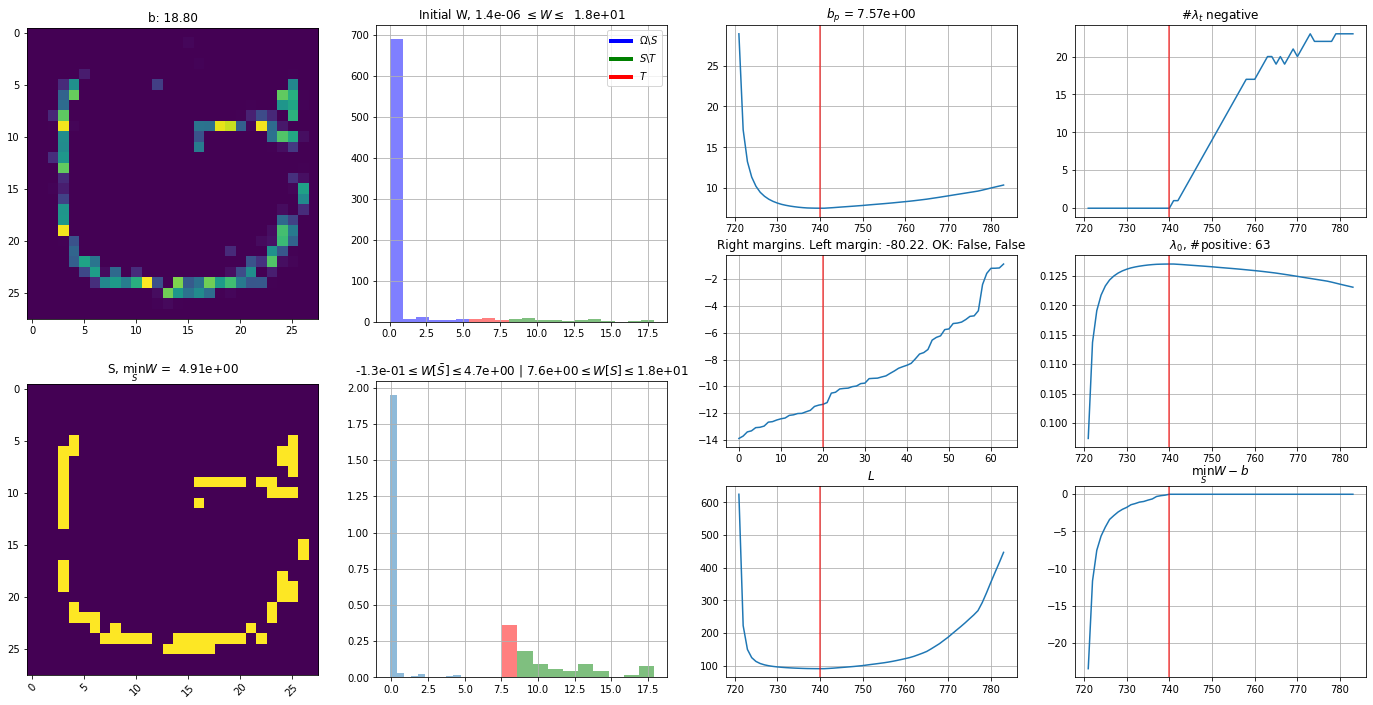

In [304]:
# chout = 30

# Interesting chouts:
# 606: left cond OK
# 863: nice binary
# 378, 488: all is good...
# 63: all is good, multiple Ts
# 316

# chout = np.random.randint(0, Ws.shape[0])
chout = 316
print("Current Channel", chout)
W = np.unique(Ws[chout])
b = bs[chout]
omega = np.ones_like(W).astype(bool)

idx_S = 720
thresh = W[idx_S]
S = W >= thresh

left_margin = b - W[~S].sum()
right_margins = W[S] - b

all_Ts = np.arange(idx_S+1, len(W))
all_res = []
for idx, idx_T in enumerate(all_Ts):
    T = S & (W <= W[idx_T])
    proj = Projection(Wini=W, bini=b, S=S, T=T).projection_left_right()
    res = proj.summary
    res["idx_T"] = idx_T
    res["T"] = T
    res["proj"] = proj
    all_res.append(res)

df = pd.DataFrame(all_res, )
df.index = df["idx_T"]
df["lambdat_neg"] = df["lambdat"].apply(lambda x: (x < -1e-5).sum())
df["Ws_min"] = df["W"].apply(lambda x: x[S].min())

good_idx = np.where(
    # (df.lambda0.values > 0) & (df["lambdat_neg"] == 0) & (df["Ws_min"] - df["b"] >= 0)
    df["right_cond_proj"] & df["left_cond_proj"]
)[0]
print("Possibles Ts:", len(good_idx))
if len(good_idx) == 0:
    best_idx = None
    print("No solution found")
else:
    # best_idx = df.index[good_idx[0][0]]
    best_idx = df["loss"].iloc[good_idx].idxmin()
    print("Lagrangien cond:", df.loc[best_idx, "proj"].lagrangian_cond())
print("Best idx", best_idx)


def plot_all():
    fig = plt.figure(figsize=(6*4, 6*2))


    ax = fig.add_subplot(241)
    ax.imshow(Ws[chout].reshape(28, 28))
    ax.set_title(f"b: {b:.2f}")
    ax.grid(False)

    ax = fig.add_subplot(245)
    ax.imshow(Ws[chout].reshape(28, 28) >= thresh)
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_title(fr"S, $\min_S W$ = {W[S].min(): .2e}")
    ax.grid(False)


    ax = fig.add_subplot(347)
    ax.plot(right_margins, )
    ax.set_title(f"Right margins. Left margin: {left_margin:.2f}. OK: {left_margin >= 0}, {(right_margins >= 0).all()}")
    if best_idx is not None:
        ax.axvline(best_idx - (omega.sum() - S.sum()), color="red", alpha=.7)


    ax = fig.add_subplot(3,4,11)
    ax.plot(all_Ts, df.loss)
    if best_idx is not None:
        ax.axvline(best_idx, color="red", alpha=.7)
    ax.set_title(r"$L$")

    ax = fig.add_subplot(344)
    ax.plot(all_Ts, df.lambdat_neg,)
    if best_idx is not None:
        ax.axvline(best_idx, color="red", alpha=.7)
    ax.set_title(r"#$\lambda_t$ negative")

    ax = fig.add_subplot(348)
    ax.plot(all_Ts, df.lambda0,)
    if best_idx is not None:
        ax.axvline(best_idx, color="red", alpha=.7)
    ax.set_title(rf"$\lambda_0$, #positive: {(df['lambda0'] > 0).sum()}")

    ax = fig.add_subplot(3,4,12)
    ax.plot(all_Ts, df["Ws_min"] - df.b,)
    if best_idx is not None:
        ax.axvline(best_idx, color="red", alpha=.7)
    ax.set_title(r"$\min_S W - b$")

    ax = fig.add_subplot(343)
    ax.plot(all_Ts, df.b,)
    if best_idx is not None:
        ax.axvline(best_idx, color="red", alpha=.7)
        ax.set_title(rf"$b_p$ = {df.loc[best_idx, 'b']:.2e}")
    else:
        ax.set_title(rf"$b_p$")


    legend_colors = [Line2D([0], [0], color="blue", lw=4),
                    Line2D([0], [0], color="green", lw=4),
                    Line2D([0], [0], color="red", lw=4)]
    legend_names = [r"$\Omega \backslash S$", r"$S \backslash T$", r"$T$"]


    ax = fig.add_subplot(2,4,2)
    _, bins, patches = ax.hist(W, bins=20)
    if best_idx is not None:
        for bin_, patch in zip(bins, patches):
            if thresh <= bin_ < df.loc[best_idx, "b"]:
                patch.set_facecolor("red")
                patch.set_alpha(.5)
            elif df.loc[best_idx, "b"] <= bin_:
                patch.set_facecolor("green")
                patch.set_alpha(.5)
            else:
                patch.set_facecolor("blue")
                patch.set_alpha(.5)
        ax.legend(legend_colors, legend_names)
    ax.set_title(rf"Initial W, {W.min():.1e} $\leq W \leq $  {W.max():.1e}")

    if best_idx is not None:
        Wbest = df.loc[best_idx, "W"]

        ax = fig.add_subplot(2,4,6)
        ax.hist(Wbest[~S], alpha=.5, density=True, bins=10, label="~S")
        ax.set_title(fr"{Wbest[~S].min():.1e}$\leq W[\bar S] \leq ${Wbest[~S].max():.1e} | {Wbest[S].min():.1e}$\leq W[S] \leq ${Wbest[S].max():.1e}")

        _, bins, patches = ax.hist(Wbest[S], alpha=.5, density=True, bins=10, label="S")
        patches[0].set_facecolor("red")
        for bin_, patch in zip(bins[1:], patches[1:]):
            patch.set_facecolor("green")
            patch.set_alpha(.5)

        # ax = fig.add_subplot(2,8,11)
        # ax.hist(Wbest[~S], alpha=.5, density=True, bins=20, label="~S")
        # ax.set_title(fr"{Wbest[~S].min():.1e}$\leq W[\bar S] \leq ${Wbest[~S].max():.1e}")

        # ax = fig.add_subplot(2,8,12)
        # _, bins, patches = ax.hist(Wbest[S], alpha=.5, density=True, bins=20, label="S")
        # ax.set_title(f"{Wbest[S].min():.1e}$\leq W[S] \leq ${Wbest[S].max():.1e}")
        # patches[0].set_facecolor("red")
        # for bin_, patch in zip(bins[1:], patches[1:]):
        #     patch.set_facecolor("green")
        #     patch.set_alpha(.5)

plot_all()


Current Channel 316
Possibles Ts: 1
Lagrangien condition: True
Constraint left False
constraint right True
Best idx 734


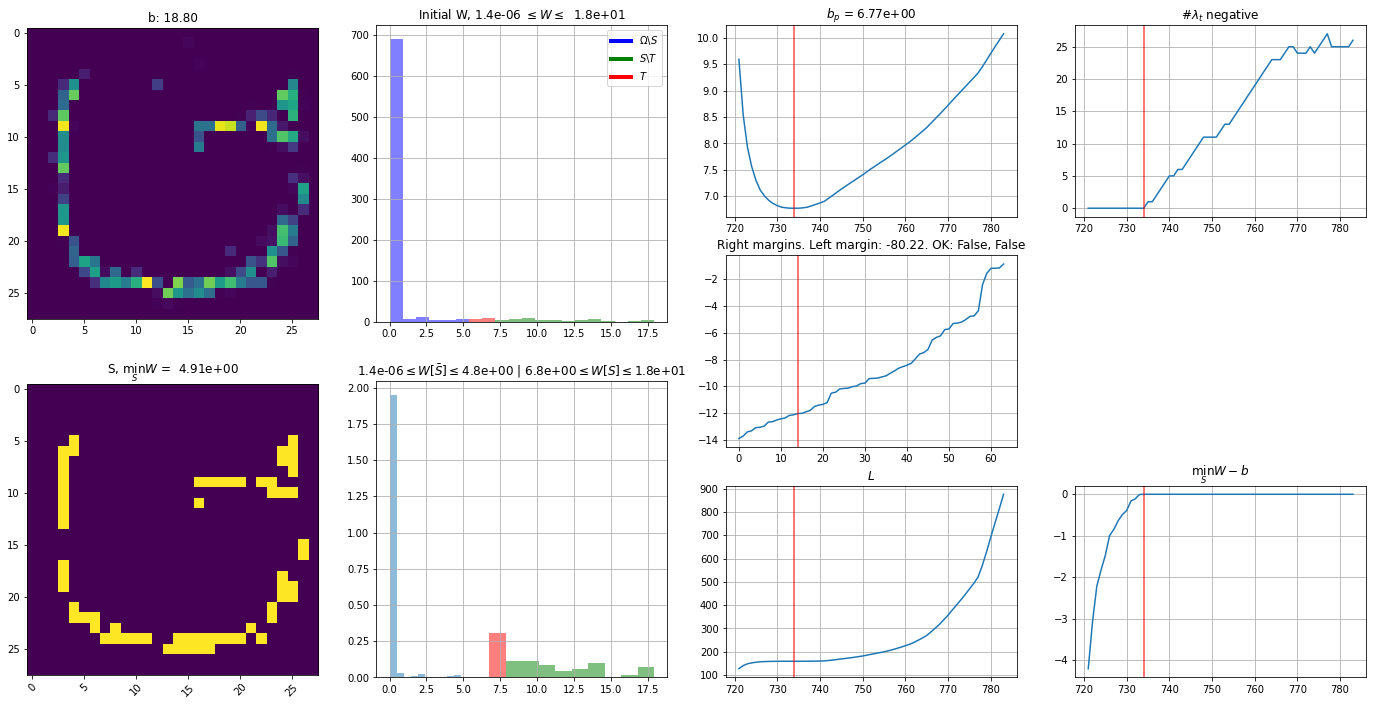

In [270]:
# Interesting channels
# chout = 63: mulitple possible Ts

# chout = np.random.randint(0, Ws.shape[0])
chout = 316
print("Current Channel", chout)
W = np.unique(Ws[chout])
b = bs[chout]
omega = np.ones_like(W).astype(bool)

idx_S = 720
thresh = W[idx_S]
S = W >= thresh

left_margin = b - W[~S].sum()
right_margins = W[S] - b


all_Ts = np.arange(idx_S+1, len(W))
all_res = []
for idx, idx_T in enumerate(all_Ts):
    T = S & (W <= W[idx_T])
    proj = Projection(Wini=W, bini=b, S=S, T=T).projection_right()
    res = proj.summary
    res["idx_T"] = idx_T
    res["T"] = T
    res["proj"] = proj
    all_res.append(res)

df = pd.DataFrame(all_res, )
df.index = df["idx_T"]
df["lambdat_neg"] = df["lambdat"].apply(lambda x: (x < 1e-5).sum())
df["Ws_min"] = df["W"].apply(lambda x: x[S].min())

good_idx = np.where(
    # (df.lambda0.values > 0) & (df["lambdat_neg"] == 0) & (df["Ws_min"] - df["b"] >= 0)
    df["right_cond_proj"] & df["lagrangian_cond"]
)[0]
print("Possibles Ts:", len(good_idx))
if len(good_idx) == 0:
    best_idx = None
    print("No solution found")
else:
    # best_idx = df.index[good_idx[0][0]]
    best_idx = df["loss"].iloc[good_idx].idxmin()
    print("Lagrangien condition:", df.loc[best_idx, "proj"].lagrangian_cond())
    print("Constraint left", df.loc[best_idx, "left_cond_proj"])
    print("constraint right", df.loc[best_idx, "right_cond_proj"])
print("Best idx", best_idx)


def plot_all():
    fig = plt.figure(figsize=(6*4, 6*2))


    ax = fig.add_subplot(241)
    ax.imshow(Ws[chout].reshape(28, 28))
    ax.set_title(f"b: {b:.2f}")
    ax.grid(False)

    ax = fig.add_subplot(245)
    ax.imshow(Ws[chout].reshape(28, 28) >= thresh)
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_title(fr"S, $\min_S W$ = {W[S].min(): .2e}")
    ax.grid(False)


    ax = fig.add_subplot(347)
    ax.plot(right_margins, )
    ax.set_title(f"Right margins. Left margin: {left_margin:.2f}. OK: {left_margin >= 0}, {(right_margins >= 0).all()}")
    if best_idx is not None:
        ax.axvline(best_idx - (omega.sum() - S.sum()), color="red", alpha=.7)


    ax = fig.add_subplot(3,4,11)
    ax.plot(all_Ts, df.loss)
    if best_idx is not None:
        ax.axvline(best_idx, color="red", alpha=.7)
    ax.set_title(r"$L$")

    ax = fig.add_subplot(344)
    ax.plot(all_Ts, df.lambdat_neg,)
    if best_idx is not None:
        ax.axvline(best_idx, color="red", alpha=.7)
    ax.set_title(r"#$\lambda_t$ negative")

    # ax = fig.add_subplot(348)
    # ax.plot(all_Ts, df.lambda0,)
    # if best_idx is not None:
    #     ax.axvline(best_idx, color="red", alpha=.7)
    # ax.set_title(rf"$\lambda_0$, #positive: {(df['lambda0'] > 0).sum()}")

    ax = fig.add_subplot(3,4,12)
    ax.plot(all_Ts, df["Ws_min"] - df.b,)
    if best_idx is not None:
        ax.axvline(best_idx, color="red", alpha=.7)
    ax.set_title(r"$\min_S W - b$")

    ax = fig.add_subplot(343)
    ax.plot(all_Ts, df.b,)
    if best_idx is not None:
        ax.axvline(best_idx, color="red", alpha=.7)
        ax.set_title(rf"$b_p$ = {df.loc[best_idx, 'b']:.2e}")
    else:
        ax.set_title(rf"$b_p$")


    legend_colors = [Line2D([0], [0], color="blue", lw=4),
                    Line2D([0], [0], color="green", lw=4),
                    Line2D([0], [0], color="red", lw=4)]
    legend_names = [r"$\Omega \backslash S$", r"$S \backslash T$", r"$T$"]


    ax = fig.add_subplot(2,4,2)
    _, bins, patches = ax.hist(W, bins=20)
    if best_idx is not None:
        for bin_, patch in zip(bins, patches):
            if thresh <= bin_ < df.loc[best_idx, "b"]:
                patch.set_facecolor("red")
                patch.set_alpha(.5)
            elif df.loc[best_idx, "b"] <= bin_:
                patch.set_facecolor("green")
                patch.set_alpha(.5)
            else:
                patch.set_facecolor("blue")
                patch.set_alpha(.5)
        ax.legend(legend_colors, legend_names)
    ax.set_title(rf"Initial W, {W.min():.1e} $\leq W \leq $  {W.max():.1e}")

    if best_idx is not None:
        Wbest = df.loc[best_idx, "W"]

        ax = fig.add_subplot(2,4,6)
        ax.hist(Wbest[~S], alpha=.5, density=True, bins=10, label="~S")
        ax.set_title(fr"{Wbest[~S].min():.1e}$\leq W[\bar S] \leq ${Wbest[~S].max():.1e} | {Wbest[S].min():.1e}$\leq W[S] \leq ${Wbest[S].max():.1e}")

        _, bins, patches = ax.hist(Wbest[S], alpha=.5, density=True, bins=10, label="S")
        patches[0].set_facecolor("red")
        for bin_, patch in zip(bins[1:], patches[1:]):
            patch.set_facecolor("green")
            patch.set_alpha(.5)

        # ax = fig.add_subplot(2,8,11)
        # ax.hist(Wbest[~S], alpha=.5, density=True, bins=20, label="~S")
        # ax.set_title(fr"{Wbest[~S].min():.1e}$\leq W[\bar S] \leq ${Wbest[~S].max():.1e}")

        # ax = fig.add_subplot(2,8,12)
        # _, bins, patches = ax.hist(Wbest[S], alpha=.5, density=True, bins=20, label="S")
        # ax.set_title(f"{Wbest[S].min():.1e}$\leq W[S] \leq ${Wbest[S].max():.1e}")
        # patches[0].set_facecolor("red")
        # for bin_, patch in zip(bins[1:], patches[1:]):
        #     patch.set_facecolor("green")
        #     patch.set_alpha(.5)

plot_all()


In [214]:
row = df.loc[best_idx]
row["left_margin_proj"]

-2.431534838032078

In [88]:
df

,b,loss,lambdat,W,left_cond_init,right_cond_init,left_cond_proj,right_cond_proj,left_margin_init,right_margin_init,left_margin_proj,right_margin_proj,idx_T,lambdat_neg,Ws_min
idx_T,,,,,,,,,,,,,,,
300,1.629967,5.313313,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.4245e-07, 7.303555e-07, 7.3487803e-07, 8.01...",True,False,True,False,3.254153,-3.259851,1.624227,-1.629925e+00,300,0,0.000042
301,1.086659,7.084416,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.4245e-07, 7.303555e-07, 7.3487803e-07, 8.01...",True,False,True,False,3.254153,-3.259851,1.080919,-1.086617e+00,301,0,0.000042
302,0.815005,7.969968,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.4245e-07, 7.303555e-07, 7.3487803e-07, 8.01...",True,False,True,False,3.254153,-3.259851,0.809265,-8.149624e-01,302,0,0.000042
303,0.652012,8.501299,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.4245e-07, 7.303555e-07, 7.3487803e-07, 8.01...",True,False,True,False,3.254153,-3.259851,0.646272,-6.519698e-01,303,0,0.000043
304,0.543351,8.855520,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.4245e-07, 7.303555e-07, 7.3487803e-07, 8.01...",True,False,True,False,3.254153,-3.259851,0.537611,-5.433082e-01,304,0,0.000043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,0.065249,44.649468,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.4245e-07, 7.303555e-07, 7.3487803e-07, 8.01...",True,False,True,True,3.254153,-3.259851,0.059509,7.744886e-10,779,39,0.065249
780,0.070518,51.085444,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.4245e-07, 7.303555e-07, 7.3487803e-07, 8.01...",True,False,True,False,3.254153,-3.259851,0.064778,-1.020204e-09,780,40,0.070518
781,0.079761,70.973087,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.4245e-07, 7.303555e-07, 7.3487803e-07, 8.01...",True,False,True,False,3.254153,-3.259851,0.074021,-8.638354e-10,781,39,0.079761


In [42]:
res

{'b': 0.3362098758006809,
 'lambda0': 0.004075122335028436,
 'loss': 0.004998593235679732,
 'W': array([-6.84337690e-04, -6.81994949e-04, -6.81279227e-04, -6.34568743e-04,
        -6.10321760e-04, -6.10107323e-04, -5.81894536e-04, -5.72075136e-04,
        -5.70392469e-04, -5.56836603e-04, -5.53418417e-04, -5.42904017e-04,
        -4.94365813e-04, -4.90110600e-04, -4.88564372e-04, -4.68207290e-04,
        -4.64741141e-04, -4.47657192e-04, -4.39827330e-04, -4.35058959e-04,
        -4.13994538e-04, -4.11971007e-04, -3.88983870e-04, -3.79149336e-04,
        -3.62965278e-04, -3.61420913e-04, -3.06463800e-04, -2.91734235e-04,
        -2.83752568e-04, -2.67298426e-04, -2.52365135e-04, -2.49844510e-04,
        -2.43491028e-04, -2.30265781e-04, -2.23579118e-04, -2.20878050e-04,
        -2.20270827e-04, -2.01140298e-04, -1.94157474e-04, -1.83420954e-04,
        -1.80545263e-04, -1.79935480e-04, -1.79336639e-04, -1.66102313e-04,
        -1.51719898e-04, -1.43922400e-04, -1.39334239e-04, -1.342864

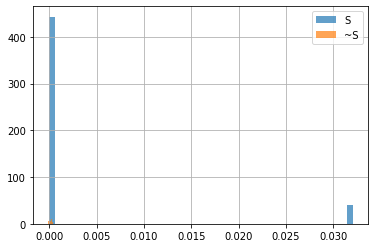

In [271]:
plt.hist(df.loc[340].W[S], label="S", alpha=.7, bins=50)
plt.hist(df.loc[340].W[~S], label="~S", alpha=.7, bins=50)
plt.legend()

1


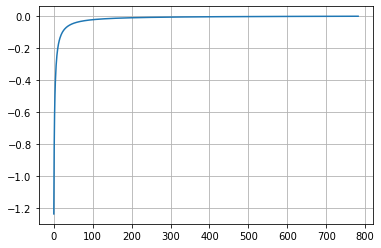

In [5]:
chout = 500
W = Ws[chout]
b = bs[chout]

w_unique = np.unique(W)
w_unique = np.concatenate([w_unique, [np.inf]])
idx = len(w_unique) // 2

barys = (np.cumsum(w_unique) + b) / (1 + np.arange(1, len(w_unique) + 1))

cond = w_unique[1:] - barys[:-1]
plt.plot(cond)
print((cond >= 0).sum())

In [6]:
lb = np.zeros_like(w_unique)
ub = np.zeros_like(w_unique)

for idx, w_value in enumerate(w_unique):
    S = W >= w_value
    lb[idx] = W[~S].sum()
    ub[idx] = W[S].min()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(w_unique, lb, label="lb", marker="o")
ax.plot(w_unique, ub, label="ub", marker="o")
ax.legend()
ax.set_yscale("log")

ax = fig.add_subplot(336)
ax.plot(w_unique[:5], lb[:5], label="lb", marker="o")
ax.plot(w_unique[:5], ub[:5], label="ub", marker="o")
ax.legend()



ValueError: zero-size array to reduction operation minimum which has no identity

In [7]:
W.sum()

0.65382797

TypeError: Invalid shape () for image data

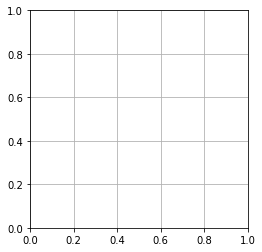

In [8]:
plt.imshow(W[0])
plt.grid(False)

In [9]:
uniques = np.zeros((Ws.shape[0], Ws.shape[1] + 1)) + np.inf
for chout in range(Ws.shape[0]):
    w_unique = np.unique(Ws[chout])
    uniques[chout, :len(w_unique)] = w_unique
barys = (np.cumsum(uniques, axis=1) + bs[:, None]) / (1 + np.arange(1, uniques.shape[1]+1))
cond = uniques[:, 1:] - barys[:, :-1]
# cond[cond <= 0] = np.inf
# Ts = np.argmin(cond, axis=1)
Ts = cond <= 0

W_replaced = np.where(Ts, Ws, 0)



/tmp/ipykernel_20833/3434477258.py:6: RuntimeWarning: invalid value encountered in subtract
  cond = uniques[:, 1:] - barys[:, :-1]


In [10]:
Ts

array([[ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True, False],
       ...,
       [ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True, False]])

In [4]:
def find_Ts(Ws, bs):
    uniques = np.zeros_like(Ws)
    for chout in range(Ws.shape[0]):
        w_unique = np.unique(Ws[chout])
        uniques[chout, :len(w_unique)] = w_unique
    cond = Ws[:, 1:] - (np.cumsum(uniques[:, :-1], axis=1) + bs[:, None]) / (1 + np.arange(1, Ws.shape[1]))
    # cond[cond <= 0] = np.inf
    # Ts = np.argmin(cond, axis=1)
    Ts = cond <= 0
    return Ts

def compute_right(Ws, bs):
    Ts = find_Ts(Ws, bs)
    new_bias = (Ws[Ts].sum(axis=1) + bs[:, None]) / (1 + Ts.sum(axis=1))
    return (((Ws - new_bias[:, None])[Ts])**2).sum(axis=1) + (new_bias - bs)**2

compute_right(Ws.reshape(-1, np.prod(Ws.shape[1:])), bs)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 784 but corresponding boolean dimension is 783

In [95]:
barycenter(W[:1], b)

4.0

In [129]:


def barycenter(W, b):
    return np.concatenate([W, [b]]).mean()

def obj(W, b):
    bary = barycenter(W, b)
    return np.sum((W - bary)**2) + (b - bary)**2

def obj_restr(W, b):
    bary = barycenter(W, b)
    return np.sum((W[:-1] - bary)**2) + (b - bary)**2 

print(barycenter(W[:1], b), obj(W[:1], b))
print(barycenter(W[:2], b), obj(W[:2], b), obj_restr(W[:2], b) - obj(W[:1], b))
print(barycenter(W[:3], b), obj(W[:3], b), obj_restr(W[:3], b) - obj(W[:2], b))
print(barycenter(W[:4], b), obj(W[:4], b), obj_restr(W[:4], b) - obj(W[:3], b))



4.0 32.0
3.0 38.0 2.0
2.75 38.75 0.1875
2.8 38.800000000000004 0.010000000000005116


In [110]:
W

array([0, 1, 2, 3, 4, 5, 6, 7])

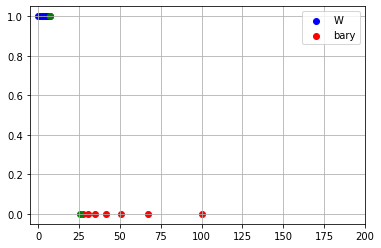

In [134]:
W = np.arange(8)
b = 200

all_barys = np.zeros(len(W))
for idx in range(len(W)):
    all_barys[idx] = barycenter(W[:idx + 1], b)

for idx in range(len(all_barys)):
    clear_output(wait=True)
    fig, ax = plt.subplots()
    
    ax.scatter(W, np.ones_like(W), c="b", label="W")
    if idx > 0:
        ax.scatter(all_barys[:idx], np.zeros(idx), c="r", label="bary")
    ax.legend()
    
    ax.scatter(all_barys[idx], np.zeros(1), c="g",)
    ax.scatter(W[idx], np.ones(1), c="g", )
    
    ax.set_xlim(xmax=b)
    plt.show()

    time.sleep(1)

    

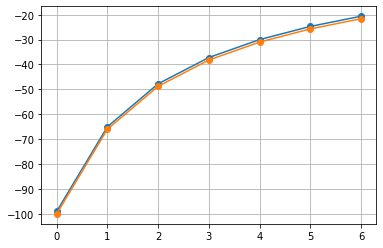

In [135]:
plt.plot(W[1:] - all_barys[:-1], marker="o")
plt.plot(W[:-1] - all_barys[:-1], marker="o")


In [ ]:


Ws = np.random.rand

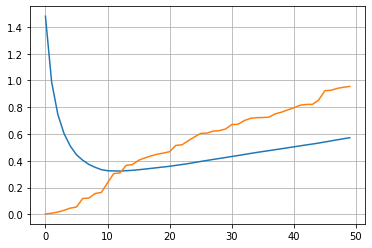

In [149]:
N = 50

W = np.unique(np.random.rand(N))
b = W.max() + 2

all_bars = np.zeros(N)

for n in range(N):
    all_bars[n] = barycenter(W[:n+1], b)

plt.plot(all_bars)
plt.plot(W)

In [ ]:
print(barycenter(W[], b))

In [11]:
def matrix_system_both(card_omega, card_S, card_T):
    A = np.zeros((card_omega - card_S + card_T + 2, card_omega - card_S + card_T + 2))

    row0, row1 = 0, card_omega - card_S
    col0, col1 = row0, row1


    A[row0:row1, col0:col1] = np.eye(card_omega - card_S)
    A[row0:row1, col1] = 1

    row0 = row1
    row1 = row0 + card_T
    
    col0 = col1 + 1
    col1 = col0 + card_T
    A[row0:row1, col0:col1] = -np.eye(card_T)
    A[row0:row1, col1] = 1

    row0 = row1
    A[row0, card_omega - card_S] = -1
    A[row0, card_omega - card_S + 1:-1] = 1
    A[row0, -1] = -1

    row0 += 1
    A[row0, :card_omega - card_S] = 1
    A[row0, -1] = -1
    return A

In [20]:
1/0.166666

6.000024000096

In [48]:
A

array([[ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1., -0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -0., -1.,  1.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  1.,  1., -1.],
       [ 1.,  1.,  1.,  1.,  1.,  0.,  0.,  0., -1.]])

In [97]:
card_omega = 11
card_S = 5
card_T = 4

A = matrix_system_both(card_omega, card_S, card_T)
Ainv = np.linalg.inv(A)
print(np.array_str((Ainv), precision=2, suppress_small=True))
# print(np.array_str((Ainv*(1 - (card_omega - card_S) * (1 - card_T))), precision=2, suppress_small=True))
# print(Ainv[0, 1] * (card_omega - card_S)+1, Ainv[-1, 0])
print((1 - card_T), Ainv[0, 1])
print(1, Ainv[-1, 0])
print((card_omega - card_S) / (1 + (card_omega - card_S) * (card_T - 1)), Ainv[-1, -2])



[[ 0.84 -0.16 -0.16 -0.16 -0.16 -0.16  0.05  0.05  0.05  0.05  0.05  0.16]
 [-0.16  0.84 -0.16 -0.16 -0.16 -0.16  0.05  0.05  0.05  0.05  0.05  0.16]
 [-0.16 -0.16  0.84 -0.16 -0.16 -0.16  0.05  0.05  0.05  0.05  0.05  0.16]
 [-0.16 -0.16 -0.16  0.84 -0.16 -0.16  0.05  0.05  0.05  0.05  0.05  0.16]
 [-0.16 -0.16 -0.16 -0.16  0.84 -0.16  0.05  0.05  0.05  0.05  0.05  0.16]
 [-0.16 -0.16 -0.16 -0.16 -0.16  0.84  0.05  0.05  0.05  0.05  0.05  0.16]
 [ 0.16  0.16  0.16  0.16  0.16  0.16 -0.05 -0.05 -0.05 -0.05 -0.05 -0.16]
 [ 0.05  0.05  0.05  0.05  0.05  0.05 -0.68  0.32  0.32  0.32  0.32 -0.05]
 [ 0.05  0.05  0.05  0.05  0.05  0.05  0.32 -0.68  0.32  0.32  0.32 -0.05]
 [ 0.05  0.05  0.05  0.05  0.05  0.05  0.32  0.32 -0.68  0.32  0.32 -0.05]
 [ 0.05  0.05  0.05  0.05  0.05  0.05  0.32  0.32  0.32 -0.68  0.32 -0.05]
 [ 0.05  0.05  0.05  0.05  0.05  0.05  0.32  0.32  0.32  0.32  0.32 -0.05]]
-3 -0.15789473684210525
1 0.052631578947368425
0.3157894736842105 0.31578947368421056


In [5]:
def matrix_system(N):
    A = np.zeros((N+1, N+1))
    A[:N, :N] = -np.eye(N)
    A[-1, :] = 1
    A[:, -1] = 1
    return A

A = np.array([
    [-1, 0, 1],
    [0, -1, 1],
    [1, 1, 1]
])

np.linalg.inv(A)

array([[-0.66666667,  0.33333333,  0.33333333],
       [ 0.33333333, -0.66666667,  0.33333333],
       [ 0.33333333,  0.33333333,  0.33333333]])

In [6]:
np.linalg.inv(matrix_system(3))

array([[-0.75,  0.25,  0.25,  0.25],
       [ 0.25, -0.75,  0.25,  0.25],
       [ 0.25,  0.25, -0.75,  0.25],
       [ 0.25,  0.25,  0.25,  0.25]])

In [7]:
def bin_to_idx(n: int, n_value: int):
    return np.array([bool(int(k)) for k in bin(n)[2:].zfill(n_value)])

In [6]:
import numpy as np
W = np.random.rand(int(1e8))

In [7]:
%%timeit
np.unique(W)

9.07 s ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
Ws = np.array([1, 2, 3, 4])
b = 3

# T = np.array([1, 1, 0, 0]).astype(bool)

def cond_fn(Ws, b, T):
    return (b + Ws[T].sum()) / (1 + T.sum())

def cond_ok(Ws, b, T):
    cond_value = cond_fn(Ws, b, T)
    return (Ws[T] <= cond_value).all()

# print(cond_fn(Ws, b, T))
# print(cond_ok(Ws, b, T))

all_Ts = []
n_values = len(Ws)
# for n in range(1, 2**n_values):
#     T = bin_to_idx(n, n_values)
#     if cond_ok(Ws, b, T):
#         all_Ts.append(T)
for wval in np.unique(Ws):
    T = Ws <= wval
    if cond_ok(Ws, b, T):
        all_Ts.append(T)
all_Ts = np.array(all_Ts).astype(int)
print(all_Ts)


[[1 0 0 0]
 [1 1 0 0]]


In [10]:
print(len(all_Ts))
all_Ts

3


array([[1, 0, 0, 0],
       [1, 1, 0, 0],
       [1, 1, 1, 0]])

# Maximize for binarization

In [3]:
def objective(W, S):
    return (W[S].sum()) ** 2 / S.sum()

def suf_cond(W, S):
    return W[S].sum() * (np.sqrt(1/S.sum() + 1) - 1)

def base10_to_base2(x, N):
    return np.array([int(x) for x in bin(x)[2:].zfill(N)]).astype(bool)

In [4]:
def run_exp(N):
    W = np.random.rand(N)

    all_dfs = []

    for i in (range(1, 2 ** N)):
        S = base10_to_base2(i, N)
        all_dfs.append(pd.DataFrame({
            'W': [W],
            'S': [S],
            'suf_cond': [suf_cond(W, S)],
            'objective': [objective(W, S)],
            'min_S': [W[S].min()],
            'max_bar': [W[~S].max() if S.sum() < N else 0],
        }, index=[i]))
    
    all_dfs = pd.concat(all_dfs)
    
    return all_dfs


def run_exp_thresh(N=None, W=None):
    if W is None:
        W = np.random.rand(N)
    W_values = np.unique(W)

    all_dfs = []

    all_Ws = []
    all_Ss = []
    # all_suf_conds = []
    all_objectives = []
    all_min_Ss = []
    all_max_bars = []
    all_values = []

    for i, value in enumerate(W_values):
        S = W >= value
        all_Ws.append(W)
        all_Ss.append(S)
        # all_suf_conds.append(suf_cond(W, S))
        all_objectives.append(objective(W, S))
        all_min_Ss.append(W[S].min())
        all_max_bars.append(W[~S].max() if S.sum() < N else 0)
        all_values.append(value)
    
    all_dfs = pd.DataFrame({
        'W': all_Ws,
        'S': all_Ss,
        # 'suf_cond': all_suf_conds,
        'objective': all_objectives,
        'min_S': all_min_Ss,
        'max_bar': all_max_bars,
        'value': all_values,
    })

        # all_dfs.append(pd.DataFrame({
        #     'W': [W],
        #     'S': [S],
        #     'suf_cond': [suf_cond(W, S)],
        #     'objective': [objective(W, S)],
        #     'min_S': [W[S].min()],
        #     'max_bar': [W[~S].max() if S.sum() < N else 0],
        #     'value': [value],
        # }, index=[i]))
    
    # all_dfs = pd.concat(all_dfs)
    
    return all_dfs


## Exploration

In [228]:
N = 7
for _ in tqdm(range(1000)):
    df = run_exp(N)

    best_line = df.iloc[df["objective"].argmax()]
    best_line.best_index = df.index[df["objective"].argmax()]

    assert best_line.min_S >= best_line.suf_cond >= best_line.max_bar, f"W[S].min()={best_line.min_S:.2f}, cond={best_line.suf_cond:.2f}, W[~S].max()={best_line.max_bar:.2f}"


  0%|          | 0/1000 [00:00<?, ?it/s]

W [0.7872216  0.52247903 0.48326671 0.31536511 0.04364566 0.06294356]
W > .5 [ True  True False False False False]
Best S [ True  True  True  True False False]
cost=1.11, W[S].min()=0.32, cond=0.25, W[~S].max()=0.06


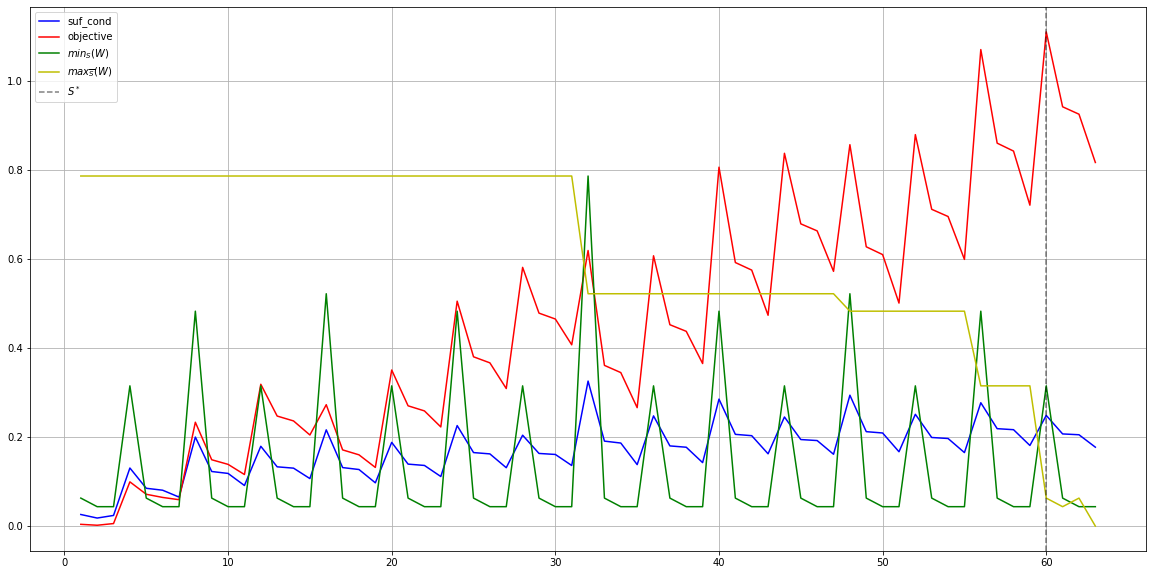

In [382]:
N = 6
# W, all_sufs, all_costs, all_mins, all_maxs_bar = run_exp(N)
df = run_exp(N)


best_line = df.iloc[df["objective"].argmax()]
best_line.best_index = df.index[df["objective"].argmax()]

print("W", best_line.W)
print("W > .5", best_line.W > .5)
max_S = best_line.S
print("Best S", max_S)
print(f"cost={best_line.objective:.2f}, W[S].min()={best_line.min_S:.2f}, cond={best_line.suf_cond:.2f}, W[~S].max()={best_line.max_bar:.2f}")

plt.figure(figsize=(20, 10))

plt.plot(df.index, df["suf_cond"], c="b", label="suf_cond")
plt.plot(df.index, df["objective"], c="r", label="objective")
plt.plot(df.index, df["min_S"], c="g", label=r"$min_S(W)$")
plt.plot(df.index, df["max_bar"], c="y", label=r"$max_{\overline{S}}(W)$")
plt.axvline(best_line.best_index, c="k", label=r"$S^*$", linestyle="--", alpha=.5)
plt.legend()
plt.grid()


In [7]:
N = 100

no = 0
nb_fails = []

for _ in tqdm(range(1000)):
    df = run_exp_thresh(N)


    best_line = df.iloc[df["objective"].argmax()]
    best_line.best_index = df.index[df["objective"].argmax()]

    der = df["objective"].iloc[1:].values - df["objective"].iloc[:-1].values

    nb_fails.append((der[:best_line.best_index] <= 0).sum() + (der[best_line.best_index:] >= 0).sum())

#     assert (der[:best_line.best_index] > 0).all() and (der[best_line.best_index:] < 0).all()

#     if not (der[:best_line.best_index] > 0).all() and (der[best_line.best_index:] < 0).all():
#         no += 1
# print(no/1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

(array([951.,   0.,   0.,   0.,   0.,  41.,   0.,   0.,   0.,   8.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

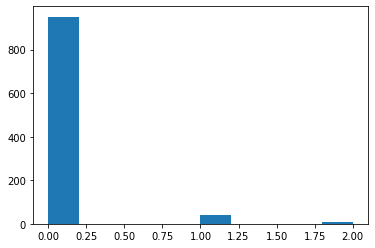

In [10]:
plt.hist(nb_fails, )

[0.67913896 0.22872692 0.68337417 0.48442038 0.69084025 0.11744174
 0.7688724  0.19031501 0.311102   0.87451352 0.64649753 0.63842616
 0.56758857 0.7740453  0.54231315 0.54024652 0.7024199  0.31477426
 0.49633606 0.39463412 0.30918276 0.33809618 0.62044768 0.6681848
 0.8247958  0.14520572 0.70064518 0.0264404  0.12210681 0.93426899]
[ True False  True  True  True False  True False False  True  True  True
  True  True  True  True  True False  True  True False  True  True  True
  True False  True False False  True]
9
[ 0.24237593  0.16069634  0.16841324  0.1559766   0.11688928  0.08315596
 -0.00466267  0.00118106  0.00576447 -0.01463758 -0.08071395 -0.19606221
 -0.20815041 -0.26560942 -0.26507759 -0.29782991 -0.37225743 -0.39697875
 -0.40723776 -0.43824795 -0.45336123 -0.45803547 -0.4673842  -0.48005401
 -0.47867963 -0.58564911 -0.59106309 -0.67606449 -0.76298854]
False
True


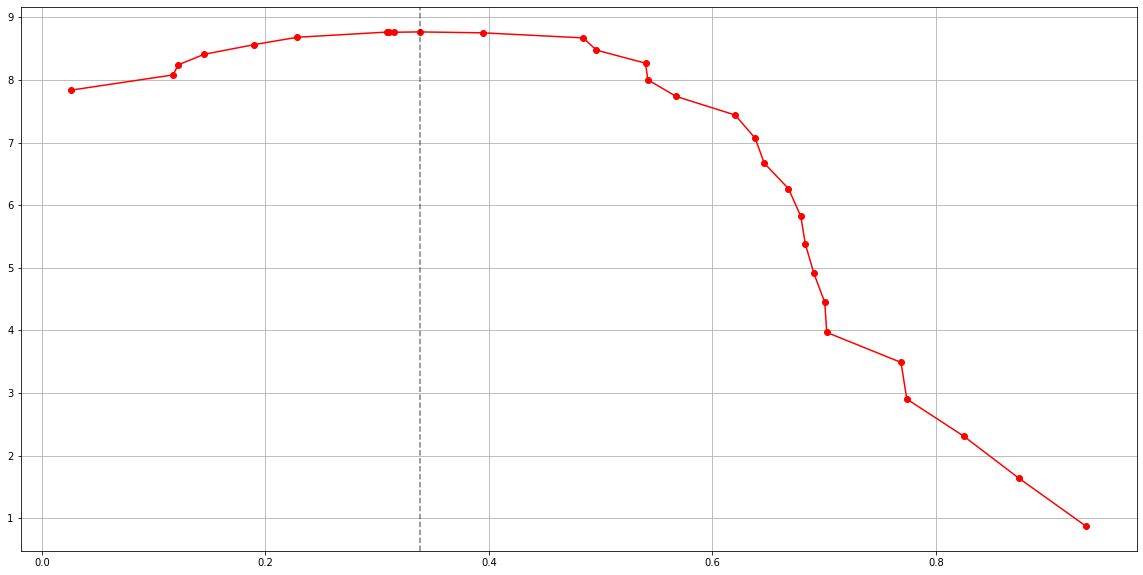

In [371]:
plt.figure(figsize=(20, 10))

plt.plot(df["value"], df["objective"], c="r", label="objective", marker="o")
plt.axvline(best_line.value, c="k", label=r"$S^*$", linestyle="--", alpha=.5)
# plt.legend()
plt.grid()

4
[ 0.25035907  0.01696279  0.03349683  0.03936302 -0.3088921  -0.37402258
 -0.56703877 -0.56483544 -0.67658462]
True
True


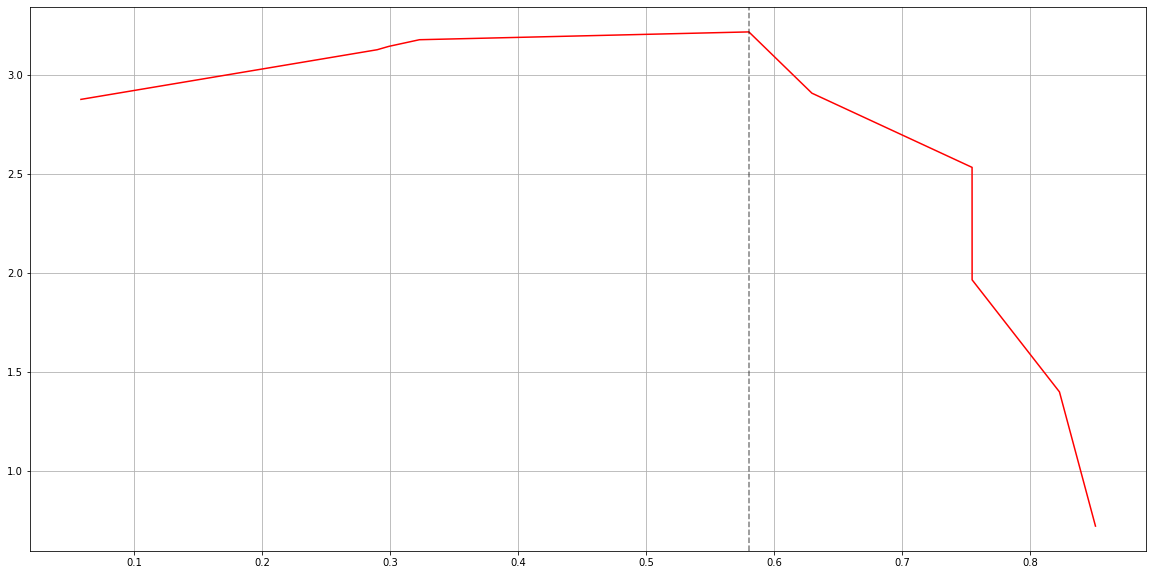

In [347]:
N = 10
# W, all_sufs, all_costs, all_mins, all_maxs_bar = run_exp(N)
df = run_exp_thresh(N)


best_line = df.iloc[df["objective"].argmax()]
best_line.best_index = df.index[df["objective"].argmax()]

# print("W", best_line.W)
# print("W > .5", best_line.W > .5)
max_S = best_line.S
# print("Best S", max_S)
# print(f"cost={best_line.objective:.2f}, W[S].min()={best_line.min_S:.2f}, cond={best_line.suf_cond:.2f}, W[~S].max()={best_line.max_bar:.2f}")
# print(df["objective"])
der = df["objective"].iloc[1:].values - df["objective"].iloc[:-1].values
print(best_line.best_index)
print(der)
print((der[:best_line.best_index] > 0).all())
print((der[best_line.best_index:] < 0).all())

plt.figure(figsize=(20, 10))

# plt.plot(df.index, df["suf_cond"], c="b", label="suf_cond")
plt.plot(df["value"], df["objective"], c="r", label="objective")
# plt.plot(df.index, df["min_S"], c="g", label=r"$min_S(W)$")
# plt.plot(df.index, df["max_bar"], c="y", label=r"$max_{\overline{S}}(W)$")
# plt.axvline(best_line.best_index, c="k", label=r"$S^*$", linestyle="--", alpha=.5)
plt.axvline(best_line.value, c="k", label=r"$S^*$", linestyle="--", alpha=.5)
# plt.legend()
plt.grid()


## Dichotomy

In [34]:
N = 20
dist_fn = objective

df = run_exp_thresh(N=N)

W = df["W"].iloc[0]


In [67]:
N = int(1e7)
W = np.random.rand(N)

In [68]:
%%timeit
dich = DichotomyBinarization(W=W, dist_fn=dist_fn)
dich.find_best_point()


5.25 s ± 9.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit
w_values = np.unique(W)


87.5 µs ± 502 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


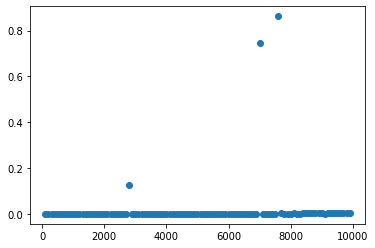

In [69]:
deltas = []
Ns = range(100, 10000, 100)
for N in tqdm(Ns):
    W = np.random.rand(N)

    delta = %timeit -o -n 5 -q dich = DichotomyBinarization(W=W, dist_fn=dist_fn).find_best_point()
    # dich = DichotomyBinarization(W=W, dist_fn=dist_fn)
    # best_pt = dich.find_best_point()
    deltas.append(delta.average)
plt.scatter(Ns, deltas)


  0%|          | 0/9 [00:00<?, ?it/s]

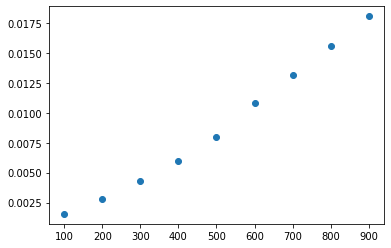

In [70]:
deltas = []
Ns = range(100, 1000, 100)
for N in tqdm(Ns):
    W = np.random.rand(N)

    delta = %timeit -o -n 5 -q run_exp_thresh(N=N)
    # dich = DichotomyBinarization(W=W, dist_fn=dist_fn)
    # best_pt = dich.find_best_point()
    deltas.append(delta.average)
plt.scatter(Ns, deltas)


In [50]:
%%timeit
run_exp_thresh(N=N)

5.37 s ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
N = 200
dist_fn = objective

df = run_exp_thresh(N=N)

W = df["W"].iloc[0]


In [5]:
from importlib import import_module
# from deep_morpho.results.results_tensorboards.Bimonn_exp_77.bimonn_last_linear.7.code.deep_morpho.models import GenericLightningModel
models_old = import_module("deep_morpho.results.results_tensorboards.Bimonn_exp_77.bimonn_last_linear.7.code.deep_morpho.models.lightning_bimonn")
LightningBiMoNNClassifierLastLinearNotBinary = models_old.LightningBiMoNNClassifierLastLinearNotBinary

weights_path = "deep_morpho/results/results_tensorboards/Bimonn_exp_77/bimonn_last_linear/7/mnistclassifchannel/bimonnclassifierlastlinearnotbinary/version_0/best_weights/epoch=26-step=21113.ckpt"
model = LightningBiMoNNClassifierLastLinearNotBinary.load_from_checkpoint(weights_path)

# torch.load(weights_path, map_location="cpu")["state_dict"]["model.classification_layer.bises.weight"]

In [132]:
a = np.array([[1, 1, 1, 2], [2, 2, 2, 3]])
np.unique(a, axis=1)

array([[1, 2],
       [2, 3]])

In [137]:
ar1 = np.unique(Ws.reshape(1000, -1), axis=1)[0]
ar2 = np.unique(Ws[0])
np.all(ar1 == ar2)

True

In [7]:
reload_modules()
Ws = model.model.layers[-1].bises.weight.detach().cpu().numpy()

best_obj_dich = []
value_dich = []
n_steps = []
for W in tqdm(Ws):
    dich = db.DichotomyBinarization(W=W, dist_fn=objective)
    best_pt = dich.find_best_point()
    best_obj_dich.append(best_pt.objective_value)
    value_dich.append(best_pt.w_value)
    n_steps.append(dich.n_steps)

best_obj_dich = np.array(best_obj_dich)

  0%|          | 0/1000 [00:00<?, ?it/s]

/hdd/aouadt/these/projets/3d_segm/deep_morpho/binarization/dichotomy_binarization.py:158: UserWarning: DichotomyBinarization: No local max found. No change in iteration.
  warnings.warn("DichotomyBinarization: No local max found. No change in iteration.")


In [8]:
Ws = model.model.layers[-1].bises.weight.detach().cpu().numpy()
N = np.prod(Ws.shape[1:])

best_obj_bl = []
value_bl = []
for W in tqdm(Ws):
    df = run_exp_thresh(N=N, W=W)
    best_line = df.iloc[df["objective"].argmax()]
    best_obj_bl.append(best_line.objective)
    value_bl.append(best_line.value)


best_obj_bl = np.array(best_obj_bl)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
diff = np.abs(best_obj_dich - best_obj_bl)
print("Pathological cases")
print(np.where(diff > 1e-3))
print(np.unique(n_steps, return_counts=True))


Pathological cases
(array([ 41,  48,  66, 179, 315, 393, 394, 447, 772]),)
(array([ 1,  3,  4,  5,  6,  7,  8,  9, 10]), array([446,   4,   2,  11,  28,  41,  95, 169, 204]))


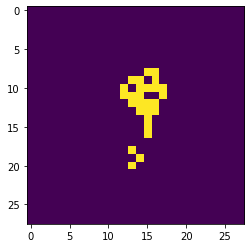

In [331]:
reload_modules()
Ws = model.model.layers[-1].bises.weight.detach().cpu()
bias = model.model.layers[-1].bises.bias

handler = bcs.BiseClosestMinDistOnCst2(model.model.layers[-1].bises)
S, op, dist = handler.find_closest_selem_and_operation(Ws, bias, chans=range(Ws.shape[0]))

idx = 41
plt.imshow(S[41, 0])
plt.grid(False)

In [349]:
failed = []
for idx in range(1000):
    if not np.all(S[idx, 0] == (Ws[idx][0] >= value_bl[idx]).detach().cpu().numpy()):
        failed.append(idx)
print(failed)

[103, 132, 268, 282, 359, 360, 578, 805, 920]


In [330]:
W = Ws[920].detach().cpu().numpy()
w_values = np.unique(W)[::-1]
best_idx = (np.cumsum(w_values) / np.sqrt(np.arange(1, len(w_values) + 1))).argmax()
print(best_idx, w_values[best_idx])


720 0.0044854297


In [350]:
reload_modules()
handler = bcs.BiseClosestMinDistOnCst2(model.model.layers[-1].bises)
w_values2 = handler.find_closest_selem_and_operation(Ws, bias, chans=range(Ws.shape[0]))
# best_idx = (np.cumsum(w_values2) / np.sqrt(np.arange(1, len(w_values2) + 1))).argmax()
# print(best_idx, w_values2[best_idx])

In [357]:
ar1 = np.arange(300*400).reshape(300, 400)
ar2 = np.random.rand(300, 400) > 0.5
res1 = np.array([ar1[k, ar2[k]].sum() for k in range(ar1.shape[0])])
res2 = np.where(ar2, ar1, 0).sum(axis=1)



In [356]:
%%timeit
np.where(ar2, ar1, 0).sum(axis=1)

492 µs ± 3.98 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [354]:
%%timeit
np.array([ar1[k, ar2[k]].sum() for k in range(ar1.shape[0])])


1.7 ms ± 48.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
w_values[920][720]
0.004485429730266333
w_values[920][719]
0.004512738902121782

In [326]:
value_bl[920]

0.0044854297

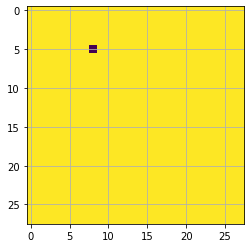

In [315]:
plt.imshow(S[920, 0] -  (Ws[920][0] >= value_bl[920]).detach().cpu().int().numpy())

In [291]:
(Ws[idx][0] >= value_bl[idx]).shape

torch.Size([28, 28])

103


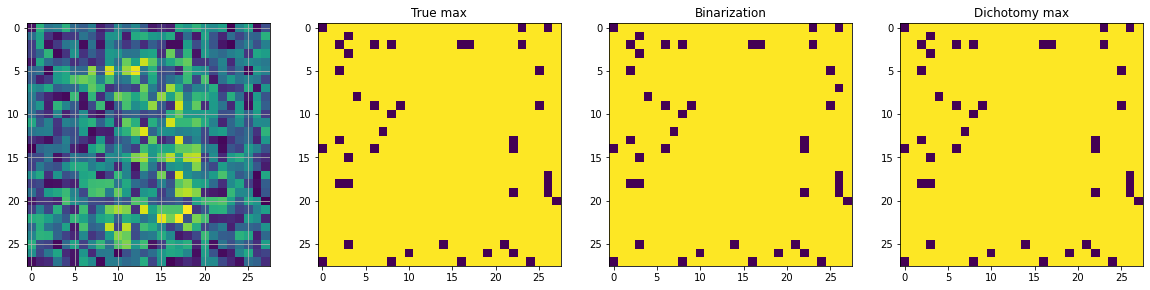

In [298]:
idx = 103
# idx = np.random.randint(0, len(Ws))
print(idx)

plt.figure(figsize=(20, 5))

plt.subplot(141);plt.imshow(Ws[idx][0])

plt.subplot(142);plt.imshow(Ws[idx][0] >= value_bl[idx], vmin=0, vmax=1);plt.title("True max");plt.grid(False)


plt.subplot(143);plt.imshow(S[idx, 0], vmin=0, vmax=1);plt.title("Binarization");plt.grid(False)


plt.subplot(144);plt.imshow(Ws[idx][0] >= value_dich[idx], vmin=0, vmax=1);plt.title("Dichotomy max");plt.grid(False)


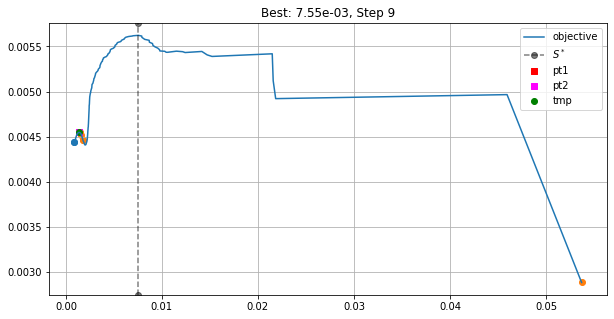

PointDichotomy(index=197, dist_S=4.55e-03) w value: 1.39e-03
True obj=5.62e-03, diff=1.07e-03, index=756


In [11]:
reload_modules()
W = Ws[idx]

df = run_exp_thresh(N=np.prod(W.shape[1:]), W=W)
dich = db.DichotomyBinarization(W=W, dist_fn=objective)
best_pt = dich.find_best_point()

print(len(best_pt.index_history))
print(best_pt.derivative)

best_line = df.iloc[df["objective"].argmax()]


dich.animate_on_curve(df["value"], df["objective"], best_value=best_line.value,)
print(dich.best_pt, f"w value: {dich.best_pt.w_value:.2e}")
print(f'True obj={df["objective"].max():.2e}, diff={np.abs(dich.best_pt.objective_value - df["objective"].max()):.2e}, index={df["objective"].argmax()}')

In [12]:
def get_indicator_index(w_values):
    """
    Args:
        w_values (np.ndarray): sorted values of W (descending)
    """
    indicator = w_values - 1 / (2 * np.arange(1, 1+len(w_values))) * np.cumsum(w_values)
    # index = np.where(indicator >= 0)[0][-1]
    negative_indices = np.where(indicator < 0)[0]
    if len(negative_indices) == 0:
        return len(w_values) - 1
    return np.where(indicator < 0)[0][0] - 1


In [112]:
%%timeit
w_values = np.unique(W)[::-1]
all_obs = []
for w in w_values:
    S = W >= w
    obj = objective(W, S)
    all_obs.append(obj)
np.argmax(all_obs)

6.69 ms ± 28.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [159]:
%%timeit
# cumsums = np.zeros((Ws.shape[0], Ws.shape[1]))
# all_w_values = np.zeros((Ws.shape[0], np.prod(Ws.shape[1:])))
for idx, W in enumerate(Ws):
    w_values = np.unique(W)[::-1]
    ((np.cumsum(w_values))**2 / np.arange(1, 1+len(w_values))).argmax()
#     all_w_values[idx, :len(w_values)] = w_values
# (np.cumsum(all_w_values, axis=1) / np.sqrt(np.arange(1, 1+all_w_values.shape[1]))).argmax(1)


21.8 ms ± 510 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [262]:
ar = np.random.rand(10, 100)
np.all(ar.max(1) == ar[np.arange(ar.shape[0]), ar.argmax(1)])

True

In [274]:
ar = np.empty((3,), dtype=str)
ar[1] = "erosion"
ar

array(['', 'e', ''], dtype='<U1')

In [265]:
 ar[np.arange(ar.shape[0]), ar.argmax(1), None, None].shape

(10, 1, 1)

In [248]:
%%timeit
# cumsums = np.zeros((Ws.shape[0], Ws.shape[1]))
all_w_values = np.zeros((Ws.shape[0], np.prod(Ws.shape[1:]))) - np.infty
for idx, W in enumerate(Ws):
    w_values = np.unique(W)[::-1]
    # ((np.cumsum(w_values))**2 / np.arange(1, 1+len(w_values))).argmax()
    all_w_values[idx, :len(w_values)] = w_values
(np.cumsum(all_w_values, axis=1) / np.sqrt(np.arange(1, 1+all_w_values.shape[1]))).argmax(1)


15.4 ms ± 456 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [167]:
np.zeros((20, 100)) / np.ones(100)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [247]:
%%timeit
W_reshape = Ws.reshape(Ws.shape[0], -1)
w_values = np.sort(np.unique(W_reshape, axis=1), axis=1)[:, ::-1]
(np.cumsum(w_values, axis=1) / np.sqrt(np.arange(1, 1+w_values.shape[0])[..., None])).argmax(1)

19.3 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [245]:
ar1 = np.unique(W_reshape, axis=1)[3]
ar2 = np.unique(Ws[3])
np.all(sorted(ar1) == ar2)

True

In [240]:
np.all(W_reshape[5] == Ws[5].reshape(-1))

True

In [213]:
np.all(w_values1[-1]== w_values2)

False

(1, 28, 28)

In [210]:
W_reshape = Ws.reshape(Ws.shape[0], -1)
w_values1 = np.unique(W_reshape, axis=1)[:, ::-1]
idxs1 = (np.cumsum(w_values1, axis=1) / np.sqrt(np.arange(1, 1+w_values1.shape[1]))).argmax(1)

idxs2 = np.zeros(Ws.shape[0], dtype=int)
for idx, W in enumerate(Ws):
    w_values2 = np.unique(W)[::-1]
    idxs2[idx] = ((np.cumsum(w_values2))**2 / np.arange(1, 1+len(w_values2))).argmax()

(idxs1 != idxs2).sum()

653

In [246]:
%%timeit
w_values = np.unique(W)[::-1]
((np.cumsum(w_values))**2 / np.arange(1, 1+len(w_values))).argmax()

AxisError: axis 1 is out of bounds for array of dimension 1

931


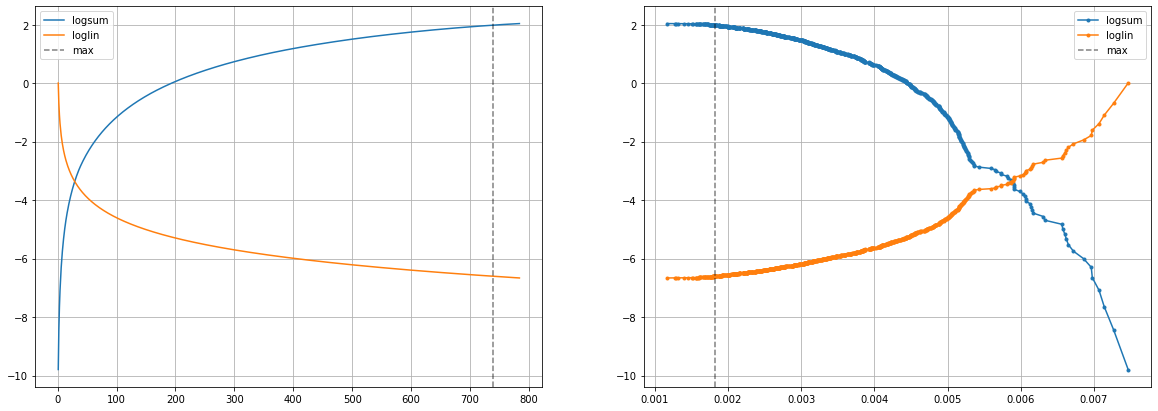

In [90]:
idx = np.random.randint(0, len(Ws));print(idx)
W = Ws[idx]
w_values = np.unique(W)[::-1]
logsum = 2 * np.log(np.cumsum(w_values))
loglin = np.log(np.arange(1, 1+len(w_values)))
xs = np.arange(1, 1+len(w_values))

plt.figure(figsize=(20, 7))

plt.subplot(121)
plt.plot(xs, logsum, label="logsum", )
plt.plot(xs, -loglin, label="loglin", )
# plt.plot(xs, logsum - loglin, label="to maximize", )
plt.axvline((logsum - loglin).argmax(), label="max", c="k", alpha=.5, ls="--")
plt.legend()


plt.subplot(122)
plt.plot(w_values, logsum, label="logsum", marker=".")
plt.plot(w_values, -loglin, label="loglin", marker=".")
# plt.plot(xs, logsum - loglin, label="to maximize")
plt.axvline(w_values[(logsum - loglin).argmax()], label="max", c="k", alpha=.5, ls="--")
plt.legend()


Indicator: index=772, w value=1.15e-02, indicator=3.87e-04, negative=0
True: index=756, w value=7.55e-03, indicator=3.32e-04, negative=1


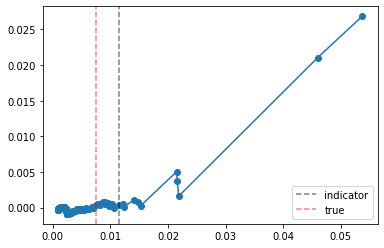

In [13]:
w_values = np.unique(W)[::-1]
indicator = w_values - 1 / (2 * np.arange(1, 1+len(w_values))) * np.cumsum(w_values)


index_best = len(w_values) - 1 - df['objective'].argmax()
index = get_indicator_index(w_values)
# index = np.where(indicator >= 0)[0][-1]
# index = np.where(indicator < 0)[0][0] + 1

plt.plot(w_values, indicator, marker="o")
plt.axvline(w_values[index], c="k", label=r"indicator", linestyle="--", alpha=.5,)
plt.axvline(w_values[index_best], c="r", label=r"true", linestyle="--", alpha=.5,)
plt.legend()

print(f"Indicator: index={(len(w_values) - 1 - index)}, w value={w_values[index]:.2e}, indicator={indicator[index]:.2e}, negative={(indicator[:index] < 0).sum()}")
print(f"True: index={len(w_values) - 1 - index_best}, w value={df['value'].iloc[df['objective'].argmax()]:.2e}, indicator={indicator[index_best]:.2e}, negative={(indicator[:index_best] < 0).sum()}")

In [314]:
delta_indicator = indicator[1:] - indicator[:-1]
(delta_indicator[:index_best] < 0).sum()
# plt.plot(delta_indicator[200:])

531

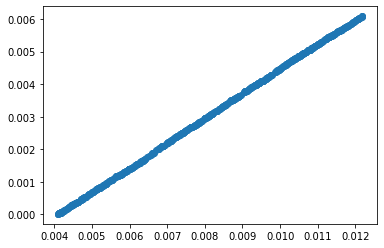

In [315]:
plt.plot(w_values[2:index_best], indicator[2:index_best], marker="o")

In [307]:
all_indicator_idx = np.zeros(Ws.shape[0])
all_best = np.zeros(Ws.shape[0])

for idx in tqdm(range(Ws.shape[0])):
    W = Ws[idx]
    df = run_exp_thresh(N=np.prod(W.shape[1:]), W=W)

    w_values = np.unique(W)[::-1]
    indicator = w_values - 1 / (2 * np.arange(1, 1+len(w_values))) * np.cumsum(w_values)
    all_best[idx] = len(w_values) - 1 - df['objective'].argmax()
    # all_indicator_idx[idx] = np.where(indicator >= 0)[0][-1]
    all_indicator_idx[idx] = get_indicator_index(w_values)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [331]:
np.where(all_best - all_indicator_idx == 16)

(array([41]),)

In [308]:
print({k:v for k, v in zip(*np.unique(all_best - all_indicator_idx, return_counts=True))})
print(np.where(all_best - all_indicator_idx != 0))

{-5.0: 1, -3.0: 1, -2.0: 6, -1.0: 53, 0.0: 933, 1.0: 1, 2.0: 1, 4.0: 1, 16.0: 1, 738.0: 1, 750.0: 1}
(array([ 34,  41,  42,  66,  69,  79, 132, 138, 148, 167, 189, 197, 207,
       214, 220, 233, 242, 244, 248, 256, 264, 268, 269, 282, 304, 305,
       309, 315, 345, 351, 355, 356, 359, 387, 394, 417, 528, 553, 564,
       565, 577, 578, 585, 590, 608, 609, 612, 634, 754, 771, 773, 776,
       780, 782, 785, 797, 805, 809, 817, 825, 833, 863, 873, 908, 915,
       921, 991]),)


# Pickle

In [5]:
import deep_morpho.datasets.gray_to_channels_dataset as gtc
from general.utils import save_yaml

In [6]:
from abc import ABC

class A(ABC):
    pass

# class B(A):
#     pass

save_yaml({"a": A}, "todelete.yaml")


In [35]:
save_yaml({"a": gtc.LevelsetValuesEqualIndex}, "todelete.yaml")


TypeError: __reduce_ex__() takes exactly one argument (0 given)

# Nb params

In [8]:
def nb_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
lb = dense_lui.DenseLUI(out_channels=50, in_channels=50)
lb.numel_float()

2600

In [12]:
lc = nn.Linear(in_features=50, out_features=50)
nb_params(lc)

2550

In [13]:
list(lc.named_parameters())

[('weight',
  Parameter containing:
  tensor([[ 0.0731,  0.0783, -0.0114,  ..., -0.0759, -0.1274,  0.0051],
          [ 0.0385, -0.1383, -0.0117,  ...,  0.0379,  0.1101,  0.0644],
          [-0.0261, -0.0986, -0.1388,  ...,  0.0279, -0.0713,  0.0635],
          ...,
          [ 0.0079, -0.0716, -0.0908,  ...,  0.0227, -0.0427,  0.0277],
          [ 0.0066,  0.1058, -0.0760,  ..., -0.1158, -0.0932,  0.0624],
          [ 0.0475,  0.0599, -0.1122,  ...,  0.0672,  0.0718,  0.0897]],
         requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([-0.0739, -0.0844,  0.0384,  0.0483, -0.0276, -0.0042,  0.0418, -0.0761,
          -0.1048,  0.1146, -0.1097, -0.0616,  0.0376, -0.1342,  0.0697, -0.0438,
          -0.0519,  0.0740, -0.1095, -0.1031, -0.1216, -0.0316, -0.0127,  0.1314,
          -0.1180,  0.0083, -0.1322, -0.0146, -0.0419,  0.1138,  0.1289, -0.0745,
           0.0625, -0.0077,  0.1136, -0.0192,  0.0903, -0.1225, -0.0146, -0.0406,
          -0.0259, -0.0463,  0.0860,  0.1

In [28]:
chin = 30
chout = 50

bisel.BiSEL(in_channels=chin, out_channels=chout, kernel_size=5, ).numel_float()

42100

In [29]:
nb_params(nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=5,)) + 3*chin*chout + chout

42100

# TB Logs

In [26]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd


scalars = ["loss/train"]
path = ("deep_morpho/results/results_tensorboards/Bimonn_exp_75/"
       "multi/0/bisel/softplus/diskorect/black_tophat/bcomplex/version_0/loss_train_loss")


ea = event_accumulator.EventAccumulator(
    path,
    size_guidance={event_accumulator.SCALARS: 0},
)
_absorb_print = ea.Reload()
last_value = ea.Scalars(ea.Tags()['scalars'][0])[-1].value
# # make sure the scalars are in the event accumulator tags
# assert all(
#     s in ea.Tags()["scalars"] for s in scalars
# ), "some scalars were not found in the event accumulator"
# df = {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}





In [25]:
ea.Tags()['scalars'][0]

'loss/train'

In [16]:
df['loss/train'].iloc[-1].value

0.007988006807863712

In [9]:
df = parse_tensorboard(path, "loss_train_loss")

AssertionError: some scalars were not found in the event accumulator

# Normalization Distribution

In [24]:
vals = []
for _ in range(100):
    X = np.random.rand(N) * (b - a) + a
    vals.append(X.sum())

vals = np.array(vals)


In [26]:

vals.std()

1802.7708268043227

In [28]:
X.mean()

2.0001321852173684

9.999999999999998e-08 5.0008959850907704e-08 1.500267692537333e-07
1e-07 5e-08 1.5e-07


(array([1002231., 1001550.,  998237.,  999717.,  999800.,  999674.,
        1000320., 1000223.,  999601.,  998647.]),
 array([5.00089599e-08, 6.00107408e-08, 7.00125217e-08, 8.00143027e-08,
        9.00160836e-08, 1.00017865e-07, 1.10019645e-07, 1.20021426e-07,
        1.30023207e-07, 1.40024988e-07, 1.50026769e-07]),
 <BarContainer object of 10 artists>)

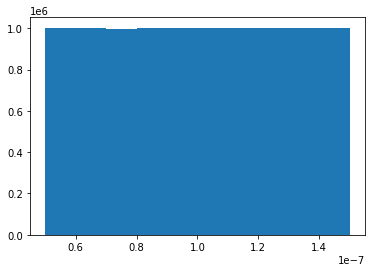

In [14]:
N = int(1e7)
a = 1
b = 3

X = np.random.rand(N) * (b - a) + a

W = X / X.sum()

print(W.mean(), W.min(), W.max())
print(1 / N, 2 * a / (N * (a + b)), 2 * b / (N * (a + b)))
plt.hist(W)

# Gradient BisE Analysis

In [3]:
model = bise.BiSE(
    kernel_size=(7, 7),
    initialiser=InitBiseConstantVarianceWeights,
    weights_optim_mode=BiseWeightsOptimEnum.THRESHOLDED,
    bias_optim_mode=BiseBiasOptimEnum.RAW,
)

loss = nn.BCELoss()

dataset = DiskorectDataset(
    random_gen_fn=get_random_diskorect_channels,
    random_gen_args={'size': (50, 50), 'n_shapes': 20, 'max_shape': (20, 20), 'p_invert': 0.5, 'n_holes': 10, 'max_shape_holes': (10, 10), 'noise_proba': 0.02, "border": (0, 0)},
    morp_operation=ParallelMorpOperations.dilation(('disk', 2)),
    len_dataset=1000,
    seed=100,
    do_symetric_output=False,
)

x, _ = dataset[0]
y = array_erosion(x[0], disk(2), return_numpy_array=False).float()

loss1 = loss(model(x[None, ...]), y[None, None, ...])
loss1.backward()

grad1 = model.bias_handler.grad + 0

model.zero_grad()
y = array_dilation(1 - x[0], disk(2), return_numpy_array=False).float()
loss2 = loss(model(1 - x[None, ...]), y[None, None, ...])
loss2.backward()

grad2 = model.bias_handler.grad + 0

assert (grad1 + grad2).abs().sum() == 0

NameError: name 'BiSE' is not defined

# Ellipse Weights

In [219]:
reload_modules()
N = 3
a = 1
std = np.sqrt(1/(0.001 * 30))
A = torch.tensor([
    [1/std**2, 0.00],
    [0.00, 1/std**2]
]).float()
mu = torch.tensor([N // 2, N // 2]).float()
# mu = torch.tensor([N // 2, N // 2])[..., None].float()

W = wl.WeightsEllipse.ellipse_matrix((N, N), mu=mu, sigma_inv=A, a_=a, )

In [220]:
def mean_theory2(n_samples, n):
    xs = np.linspace(0, n, n_samples)
    return np.exp(-(xs - n/2)**2 / (std ** 2)).mean()

def cdf_not_norm(x, std):
    return np.sqrt(np.pi) * std * torch.erf(torch.tensor([x / std]))

def mean_theory(std, n):
    n = n - 1
    return 1 / n**2 * std ** 2 * np.pi * torch.erf(torch.tensor(n) / (2 * std)) ** 2

def var_theory(std, n):
    n = n - 1
    return 1 / n**2 * std ** 2 / 2 * np.pi * torch.erf(n / torch.sqrt(torch.tensor(2)) * 1 / std) ** 2 - mean_theory(std, n+1) ** 2

print()
print("Mean exp", mean_theory2(n_samples=100000, n=N-1) ** 2)
print("With erf", (cdf_not_norm(N//2, std=std) /(N-1) ) ** 2)

print()
print('Mean theory', mean_theory(std=std, n=N))
print('Mean discrete', W.mean())

print()
print("std theory", torch.sqrt(var_theory(std=std, n=N)))
print("std discrete", W.std())


Mean exp 0.9802765535302331
With erf tensor([0.9803], dtype=torch.float64)

Mean theory tensor(0.9803)
Mean discrete tensor(0.9610)

std theory tensor(0.0124)
std discrete tensor(0.0205)


In [142]:
n = 6*6
torch.erf(torch.tensor([n / std]))

tensor([1.], dtype=torch.float64)

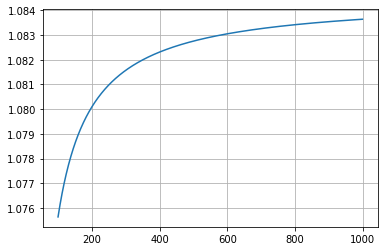

In [123]:



    
xs = np.arange(11)
mean_discrete = np.exp(-(xs - N//2)**2 / (std ** 2)).mean() ** 2

all_samples = np.arange(100, 1000)
res = []
res2 = []
for n_sample in all_samples:
    res.append(mean_theory2(n_sample) / mean_discrete)
    res2.append(mean_theory2(n_sample) / mean_theory(std=std, n=N*M))
plt.plot(all_samples, res, label='discrete')
# plt.plot(all_samples, res2, label='theory')
plt.grid()

tensor(0.5864) tensor(0.2060)
tensor([0.0005])


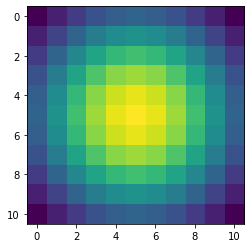

In [121]:
print(W.mean(), W.std())
print(mean_theory(std, N * M))
plt.imshow(W)

In [56]:
def var_w(n, sigma):
    return (
        4 / (n**2) * np.exp(- 2 * np.arange(n // 2) / sigma).sum()** 2 -
        (16 / n ** 4) * np.exp(- np.arange(n // 2) / sigma).sum()** 4
    )

100

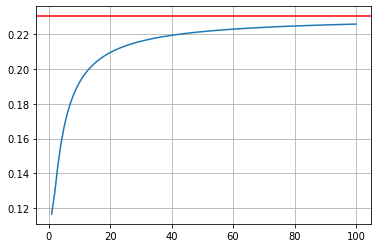

In [91]:
xs = np.linspace(1, 100, 100)
ys = []

n = 5

for x in xs:
    ys.append(var_w(n=n, sigma=x))


plt.axhline(4/(n**2) * (n // 2)**2 - (16 / (n**4)) * (n // 2)**4, c='r')
plt.plot(xs, ys)

plt.grid('on')

0.19491878384006656

In [5]:
torch.ones((3, 4, 5)).transpose(2, 1).shape

torch.Size([3, 5, 4])

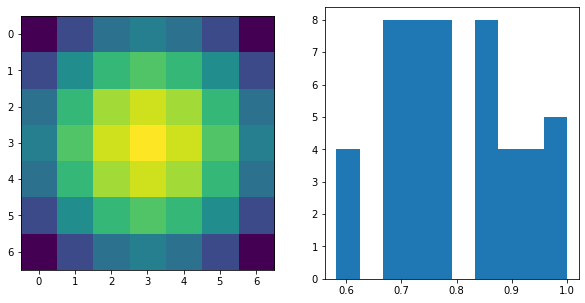

In [55]:
def ellipse_level_torch(x: torch.Tensor, mu: torch.Tensor, sigma_inv: torch.Tensor, a):
    A1 = (x - mu).T @ sigma_inv
    A2 = (x - mu).T
    res = torch.bmm(A1[:, None, :], A2[..., None])
    return torch.exp(-res ** a)

N, M = 7, 7
a = 1
A = torch.tensor([
    [0.001, 0.00],
    [0.00, 0.001]
]).float() * 30
mu = torch.tensor([N // 2, M // 2])[..., None].float()

el1 = partial(ellipse_level_torch, mu=mu, sigma_inv=A, a=a)

# XX, YY = torch.tensor(np.meshgrid(np.arange(N), np.arange(N)))
# coords = torch.tensor(np.vstack([XX.flatten(), YY.flatten()]))

XX, YY = torch.meshgrid(torch.arange(N), torch.arange(M))
coords = torch.vstack([XX.flatten(), YY.flatten()])


W = el1(coords).reshape(N, M)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(W);
plt.subplot(122)
plt.hist(W.flatten().numpy());

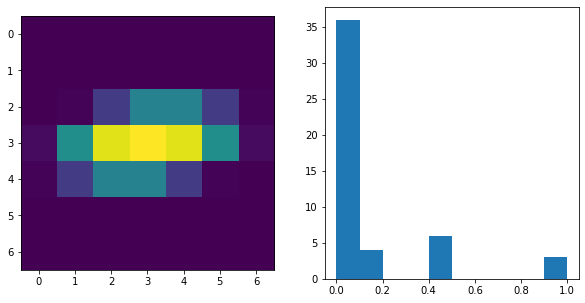

In [30]:
def ellipse_level(x: np.ndarray, mu: np.ndarray, sigma_inv: np.ndarray, a):
    return np.diag(np.exp(-((x - mu).T @ sigma_inv @ (x - mu)) ** a))

N = 7
a = 2
A = np.array([
    [0.007, 0.003],
    [0.004, 0.03]
]) * 30
mu = np.array([N // 2, N // 2])[..., None]

el1 = partial(ellipse_level, mu=mu, sigma_inv=A, a=a)

XX, YY = np.meshgrid(np.arange(N), np.arange(N))
coords = np.vstack([XX.flatten(), YY.flatten()])

W = el1(coords).reshape(N, N)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(W);
plt.subplot(122)
plt.hist(W.flatten());

In [19]:
W.shape

(2500,)

In [15]:
(coords - mu).T.shape

(2, 2500)

# Array Morphology

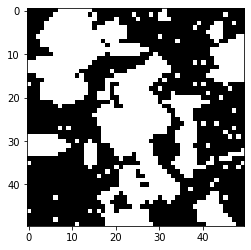

In [7]:
img = gf3.get_random_rotated_diskorect(size=(50, 50), border=(0, 0))
plt.imshow(img, cmap='gray')

Erosion


Text(0.5, 1.0, 'Difference')

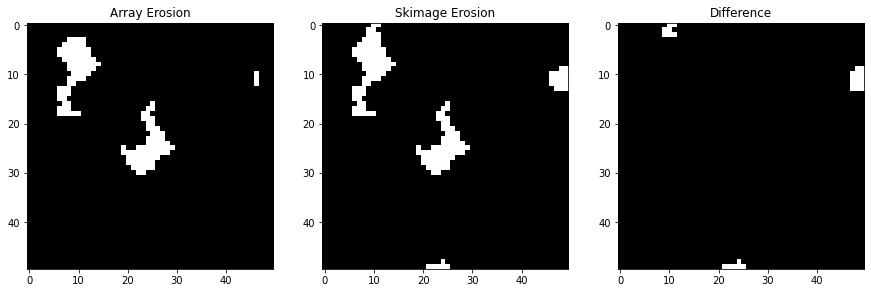

In [18]:
selem = morp.disk(3)
ero1 = arm.array_erosion(img, selem)
ero2 = morp.erosion(img, selem)

print('Erosion')

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(ero1, cmap='gray', interpolation="nearest")
plt.title('Array Erosion')

plt.subplot(132)
plt.imshow(ero2, cmap='gray', interpolation="nearest")
plt.title('Skimage Erosion')

plt.subplot(133)
plt.imshow(np.abs(ero2 - ero1), cmap='gray', interpolation="nearest")
plt.title('Difference')

Dilation


Text(0.5, 1.0, 'Difference')

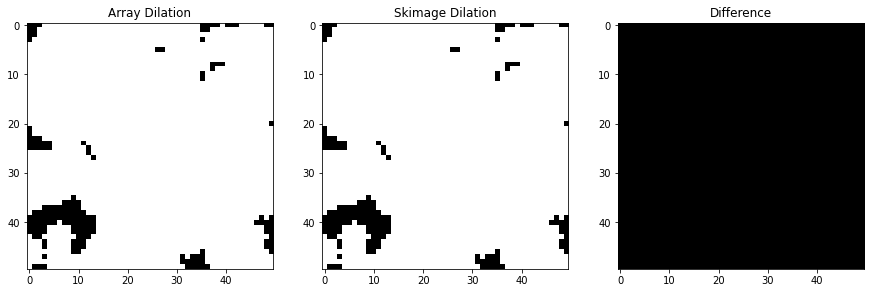

In [19]:
selem = morp.disk(3)
ero1 = arm.array_dilation(img, selem)
ero2 = morp.dilation(img, selem)

print('Dilation')

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(ero1, cmap='gray', interpolation="nearest")
plt.title('Array Dilation')

plt.subplot(132)
plt.imshow(ero2, cmap='gray', interpolation="nearest")
plt.title('Skimage Dilation')

plt.subplot(133)
plt.imshow(np.abs(ero2 - ero1), cmap='gray', interpolation="nearest")
plt.title('Difference')

Text(0.5, 1.0, 'Difference')

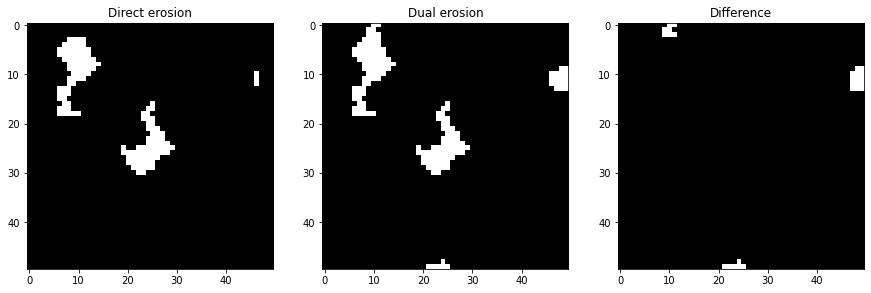

In [20]:
ero1 = arm.array_erosion(img, selem)
ero2 = 1 - arm.array_dilation(1 - img, selem)

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(ero1, cmap='gray', interpolation="nearest")
plt.title('Direct erosion')

plt.subplot(132)
plt.imshow(ero2, cmap='gray', interpolation="nearest")
plt.title('Dual erosion')

plt.subplot(133)
plt.imshow(np.abs(ero2 - ero1), cmap='gray', interpolation="nearest")
plt.title('Difference')

# Some level sets

In [2]:
N = 200

XX, YY = np.meshgrid(np.arange(N), np.arange(N))

In [3]:
def plot_lvset_ax(ax, im, eps=2e-3):
    mask = np.zeros_like(im)
    im_norm = im / im.max()
    mask[(-eps < im_norm) & (im_norm < eps)] = 1
    mask = np.ma.masked_where(mask == 0, mask)
    ax.imshow(im, cmap='gray')
    ax.imshow(mask, cmap='jet')

In [4]:
def get_circle_fn(center, radius):
    def fn(*x):
        return np.sqrt((x[0] - center[0])**2 + (x[1] - center[1])**2) - radius
    return fn

def Rtheta(theta):
    return np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])

def get_square_fn(center, radius, angle):
    def fn(*x):
        W, L = x[0].shape
        Xs = x[0].reshape(W*L)
        Ys = x[1].reshape(W*L)
        coords = np.vstack((Xs, Ys))
        return (
            np.abs(Rtheta(angle) @ (coords - center[..., np.newaxis])).sum(0) - radius
        ).reshape(W, L)
    return fn


In [71]:
def get_ellipse_fn(center, matrix, radius):
    def fn(*x):
        W, L = x[0].shape
        Z = np.zeros_like(x[0])
        for i in range(W):
            for j in range(L):
                coord = np.array([x[0][i, j], x[1][i, j]]) - center
                coord = coord[:, np.newaxis]
                Z[i, j] = np.sqrt( coord.T @ matrix @ coord) - radius
        return Z
    return fn

In [119]:
A = np.array([
    [4, 2],
    [2, 2]
]) * 5
center = np.array([75, 60])
radius = 100

fn_ellipse = get_ellipse_fn(center, A, radius)
lvset = fn_ellipse(XX, YY)

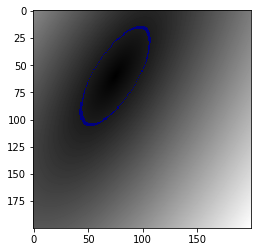

In [120]:
fig, ax = plt.subplots()
plot_lvset_ax(ax, lvset, 5e-3)

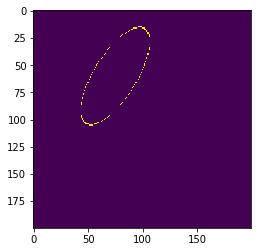

In [123]:
eps = 1e-1
mask = np.zeros_like(lvset)
mask[(-eps < lvset) & (lvset < eps)] = 1
plt.imshow(mask, interpolation='nearest')

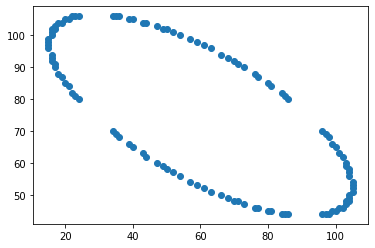

In [124]:
Xs, Ys = np.where(mask)
plt.scatter(Xs, Ys)

In [115]:
c = np.array([100, 100])
r = 50
theta = np.pi / 3

sq_fn = get_square_fn(c, r, theta)

lvset = sq_fn(XX, YY)

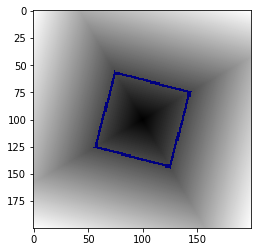

In [6]:
fig, ax = plt.subplots()
plot_lvset_ax(ax, lvset, 2e-2)

In [180]:
c = np.array([150, 100])
r = 20

cir_fn = get_circle_fn(c, r)

lvset = cir_fn(XX, YY)

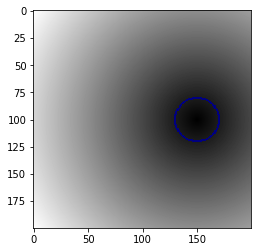

In [182]:
fig, ax = plt.subplots()
plot_lvset_ax(ax, lvset, 1e-2)

# Plot Symbols

<AxesSubplot:>

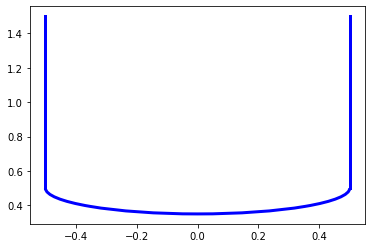

In [8]:
reload_modules()

fig, ax = plt.subplots(1,1)

ps.plot_union_on_ax(ax, [0, 1], color='blue', linewidth=3)

<AxesSubplot:>

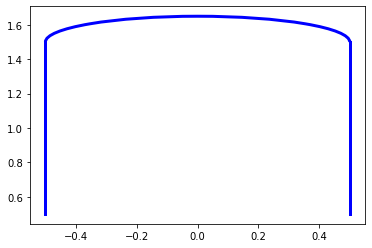

In [42]:
reload_modules()

fig, ax = plt.subplots(1,1)

ps.plot_intersection_on_ax(ax, [0, 1], color='blue', linewidth=3)

<AxesSubplot:>

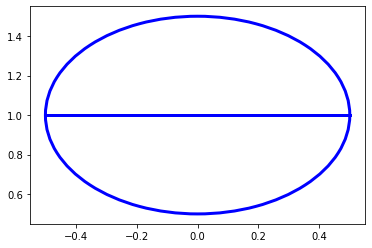

In [9]:
reload_modules()

fig, ax = plt.subplots(1,1)

ps.plot_erosion_on_ax(ax, [0, 1], color='blue', linewidth=3)

<AxesSubplot:>

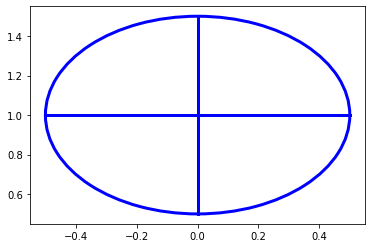

In [47]:
reload_modules()

fig, ax = plt.subplots(1,1)

ps.plot_dilation_on_ax(ax, [0, 1], color='blue', linewidth=3)

<AxesSubplot:>

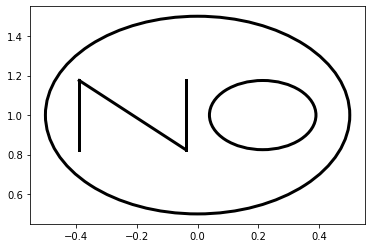

In [33]:
reload_modules()

fig, ax = plt.subplots(1,1)

plet.plot_NO_on_ax(ax, width=1, center=[0, 1], linewidth=3)

<AxesSubplot:>

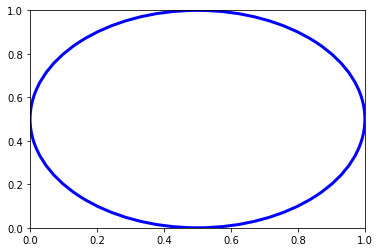

In [23]:
reload_modules()

fig, ax = plt.subplots(1,1)

plet.plot_O_on_ax(ax, height=1, center=[0.5, .5], color='blue', linewidth=3)

# Plot Histogram

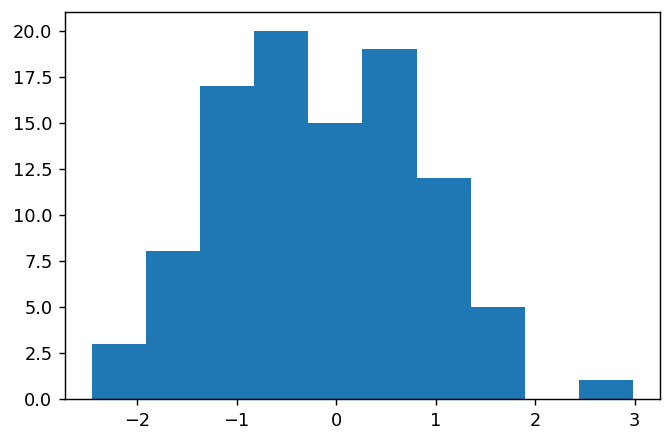

In [24]:
x = np.random.randn(100)

fig, ax = plt.subplots(dpi=128)
ax.hist(x);

In [22]:
x = 2 * (torch.rand((32, 1, 50, 50)).view(-1).numpy() + 20)
ar = ph.get_hist_as_array(x, dpi=50, density=True)
print(ar.shape)
# plt.imshow(ar)



(200, 300, 4)


# Plot Parallel Morp Ops

In [3]:
# morp_operation = mo.ParallelMorpOperations(
#     operations=[
#         [
#             [("erosion", ("vstick", 7), False), "intersection"],
#             [("dilation", ("dcross", 7), False), "union"]
#         ],
#         [
#             [("dilation", ("scross", 7), False), ("erosion", ("square", 7), False), ("intersection", [0])],
#             [("dilation", ("scross", 7), False), ("erosion", ("square", 7), False), "intersection"],
#         ],
#     ]
# )
# morp_operation = mo.ParallelMorpOperations.opening(("disk", 3))
morp_operation = mo.ParallelMorpOperations.black_tophat(('disk', 3))

Viz 1


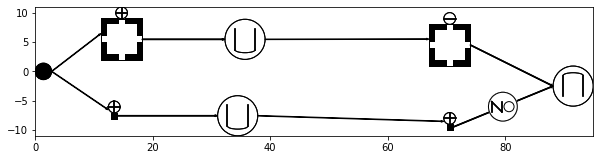

In [38]:
reload_modules()
visu = mov.MorpOperationsVizualiser(morp_operation);
# layer_group = visu.get_layer_group(0)
visu.draw(figsize=(10, 10), axis="on")
print("Viz 1")


Viz 2


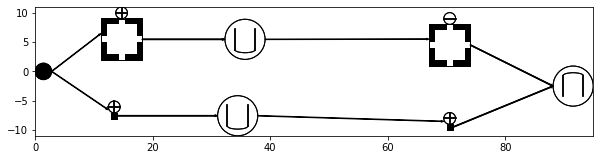

In [23]:
reload_modules()
visu = mov2.MorpOperationsVizualiser(morp_operation);
# layer_group = visu.get_layer_group(0)
visu.draw(figsize=(10, 10), axis="on")
print("Viz 2")


# Plot SMorph

In [10]:
import deep_morpho.biblio_comparison.models as bmod
import deep_morpho.biblio_comparison.vizualiser as bviz

def reload_biblio():
    for modl in [bmod, bviz]:
        reload(modl)

In [32]:
reload_biblio()
model = bmod.NetAdaptativeMorphologicalLayer(
    kernel_size=[(7, 7), (7, 7)],
)

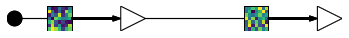

In [33]:
reload_biblio()
bviz.SequentialWeightVizualiser(model).draw()

# Plot BiMoNN

In [10]:
net = bimonn.BiMoNN(
    kernel_size=[5, 5],
    channels=[1, 3, 1],
    atomic_element="bisel",
    threshold_mode={
        "weight": 'softplus',
        "activation": 'tanh',
    },
)
# net = bimonn.BiMoNNC(
#     kernel_size=[5, 5],
#     input_size=(28, 28),
#     n_classes=10,
#     channels=[1, 2, 1],
#     atomic_element="bisel",
#     threshold_mode="tanh",
#     constant_activation_P=False,
#     constant_weight_P=True,
#     init_weight_mode="conv",
# )

In [18]:
bisel_layer.bises.conv.weight.shape

torch.Size([6, 1, 5, 5])

In [28]:
bisel_layer = net.layers[0]
new_weights = torch.zeros_like(bisel_layer.bises.weights)
new_sets = torch.zeros_like(bisel_layer.luis.weights)


for chin in range(2):
    for chout in range(3):
        weights_00 = torch.zeros_like(bisel_layer.bises.weight[0, 0, ...]) + .1
        weights_00[chin, chout] = 1
        new_weights[bisel_layer.convert_chin_chout_bise_chan(chin=chin, chout=chout), 0, ...] = weights_00

        sets_00 = torch.zeros_like(bisel_layer.luis.weight[0, 0, ...]) + chin + 1
        new_sets[chout, chin, ...] = sets_00

net.layers[0].bises.set_param_from_weights(new_weights)
net.layers[0].luis.set_param_from_weights(new_sets)


tensor([[[[0.5413]],

         [[1.8546]]],


        [[[0.5413]],

         [[1.8546]]],


        [[[0.5413]],

         [[1.8546]]]])

In [7]:
net.binary();

Viz 1


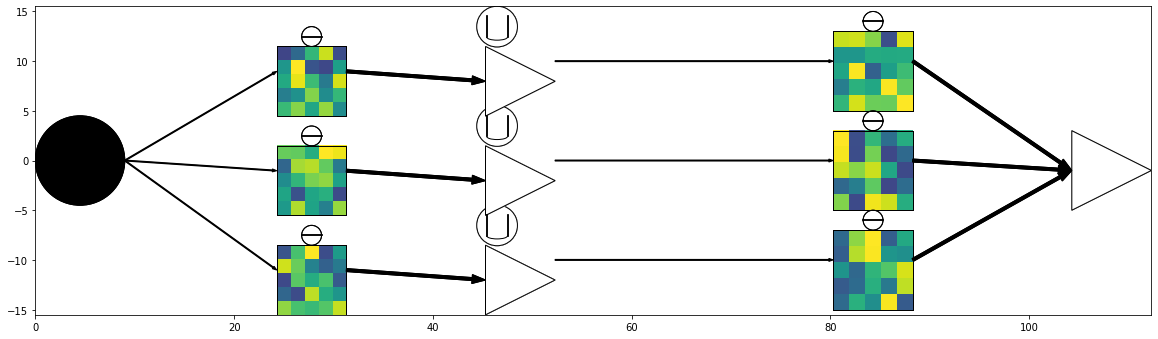

In [14]:

# viz = bviz.BimonnVizualiser(net, mode='learned')
viz = bviz.BimonnVizualiser(net, mode='weights')
viz.draw(axis="on", figsize=(20, 10))
print('Viz 1')

Viz 1


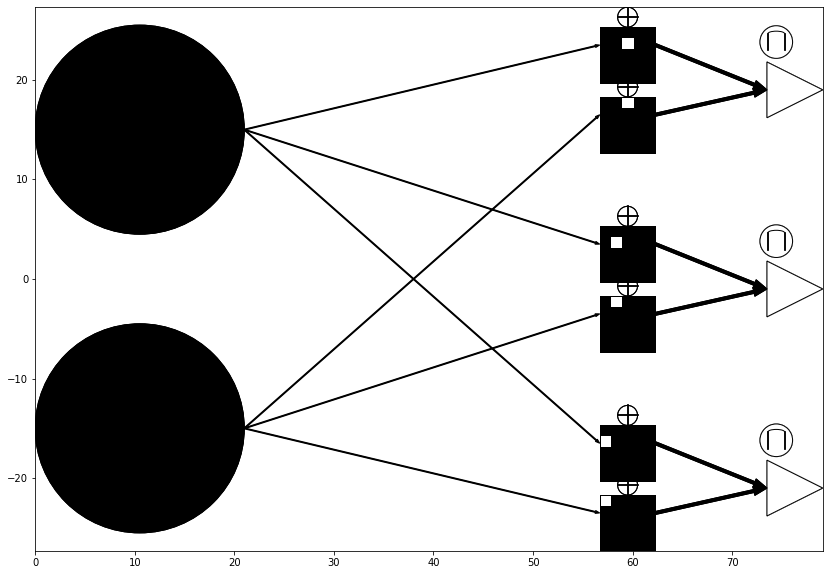

In [22]:
reload_modules()
# viz = bviz.BimonnVizualiser(net, mode='learned')
viz = bviz.BimonnVizualiser(net, mode='closest')
viz.draw(axis="on", figsize=(20, 10))
print('Viz 1')

Viz 2


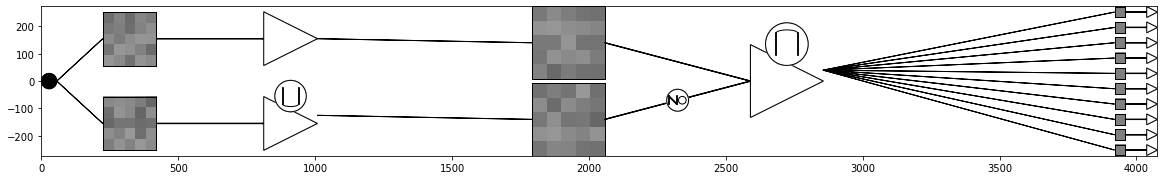

In [5]:
reload_modules()
viz = bviz.BimonnVizualiser(net, mode="weights")
viz.draw(axis="on", figsize=(20, 10))
print("Viz 2")

Viz 2


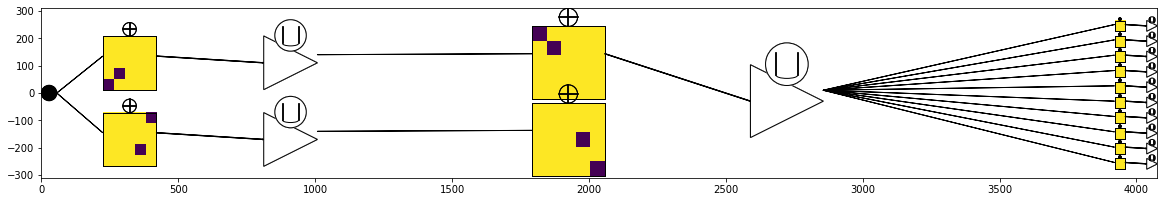

In [6]:
reload_modules()
viz = bviz.BimonnVizualiser(net, mode="closest")
viz.draw(axis="on", figsize=(20, 10))
print("Viz 2")

[6. 3.]
[56.       19.115625]
[96. 26.]
[136.   24.5]
[176.   17.5]


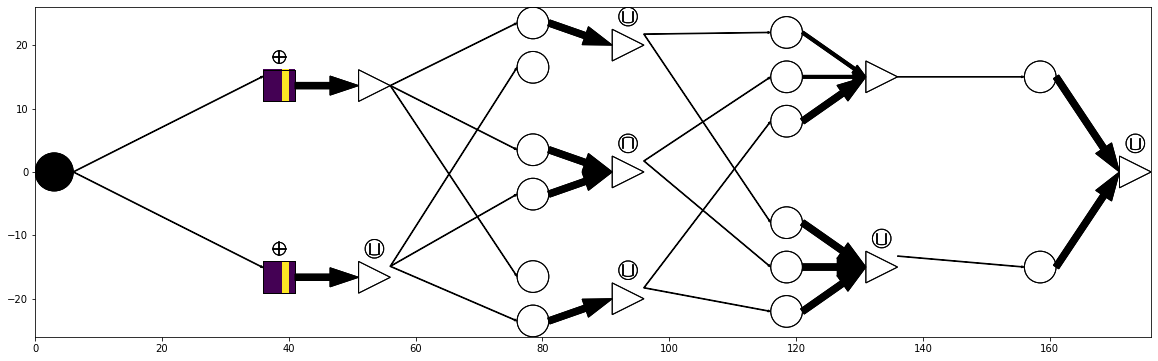

In [44]:
reload_modules()
viz = bviz.BimonnVizualiser(net, mode='selem')
viz.draw(axis="on", figsize=(20, 10))

In [81]:
viz.box_height

42

In [45]:
viz.box_height

60

# Faisable binary sets

In [49]:
# S1 = (1, 0)
xs = np.arange(20)
ys = np.arange(20)
zs = np.arange(20)

S1 = []
for x in xs:
    for y in range(x + 1, 20):
        for z in range(x, y):
            S1.append(np.array([x, y, z]) / 20)
S1 = np.array(S1)

S2 = []
for y in xs:
    for x in range(y + 1, 20):
        for z in range(y, x):
            S2.append(np.array([x, y, z]) / 20)
S2 = np.array(S2)

S3 = []
for x in xs:
    for y in ys:
        for z in range(0, min(x, y)):
            S3.append(np.array([x, y, z]) / 20)
S3 = np.array(S3)

In [53]:
plot_S1 = k3d.points(positions=S1[::10], point_size=0.01, color=0xff0000)
plot_S2 = k3d.points(positions=S2[::10], point_size=0.01, color=0x4dff00)
plot_S3 = k3d.points(positions=S3[::10], point_size=0.01,)

plot = k3d.plot()
plot += plot_S1 + plot_S2 + plot_S3
plot

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera_animation=[], camer…

In [58]:
plot_S1 = k3d.points(positions=S1[::10], point_size=0.01, color=0xff0000)
plot_S2 = k3d.points(positions=S2[::10], point_size=0.01, color=0x4dff00)
plot_S3 = k3d.points(positions=S3[::10], point_size=0.01,)


plot = k3d.plot()
vertices_w2 = [[0, 0, 0], [0, 1, 1], [1, 0, 0], [1, 1, 1]]
indices_w2 = [[0, 1, 2], [1, 2, 3]]
mesh_w2 = k3d.mesh(vertices_w2, indices_w2, opacity=.9, color=0xff0000)

vertices_w1 = [[0, 0, 0], [1, 0, 1], [0, 1, 0], [1, 1, 1]]
indices_w1 = [[0, 1, 2], [1, 2, 3]]
mesh_w1 = k3d.mesh(vertices_w1, indices_w1, opacity=.9, color=0x4dff00)


plot += plot_S1 + plot_S2 + plot_S3
plot += mesh_w2
plot += mesh_w1
plot

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera_animation=[], camer…

Text(0, 0, '01-01-2022')

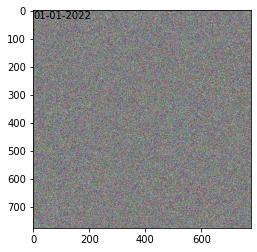

In [17]:

W = np.random.randint(300, 800)
img = np.random.rand(W, W, 3)

def plot_string_on_img(img, text, savepath):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(img)
    ax.text(0, 0, text, ha="left", va="top")
    fig.savefig(savepath)


In [3]:
help()

2